# Evaluación de Modelos LLM en Modismos Colombianos

Este notebook evalúa qué tan bien los modelos LLM entienden los modismos colombianos usando:
- **BERTScore**: Para comparar similitud semántica entre textos (definiciones)
- **AlignScore**: Para evaluar consistencia entre contexto y afirmaciones
- **Accuracy/Exact Match**: Para clasificación y coincidencias exactas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuracion
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Estilos para graficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Modelos
MODEL_NAMES = ["Amazon_Nova_Micro_V1", "Cohere_Command_R_08_2024"]

# Directorios
DATA_DIR = 'Data_for_Metrics'
OUTPUT_DIR = 'Metricas_Resultados'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Datos en: {DATA_DIR}")
print(f"Resultados en: {OUTPUT_DIR}")

Datos en: Data_for_Metrics
Resultados en: Metricas_Resultados


## 1. Cargar Funciones de Métricas

## Guía de Métricas Utilizadas

### BERTScore
**Qué mide:** Similitud semántica entre dos textos usando embeddings contextuales de BERT.

**Cómo funciona:**
- Compara palabras entre candidato y referencia usando similitud de coseno
- **Precision (P):** ¿Qué tan relevante es el texto generado? (candidato → referencia)
- **Recall (R):** ¿Qué tan completo es respecto a la referencia? (referencia → candidato)
- **F1:** Media armónica de Precision y Recall

**Uso en este proyecto:**
- ✓ Prompt 1: Comparar definiciones generadas vs reales
- ✓ Prompt 4b: Comparar definiciones de sinónimos vs definiciones reales

**Rango:** 0 a 1 (más alto = mejor)

---

### AlignScore
**Qué mide:** Consistencia factual entre un contexto (verdad) y una afirmación (claim).

**Cómo funciona:**
- Evalúa si el "claim" es factualmente consistente con el "context"
- Detecta contradicciones, alucinaciones e irrelevancias
- Usa división en chunks (contexto) y oraciones (claim) para análisis fino

**Uso en este proyecto:**
- ✓ Prompt 3: ¿El modismo generado es consistente con su definición?
- ✓ Prompt 4a: ¿El ejemplo con sinónimo mantiene el significado del original?

**Parámetros correctos:**
- `contexts`: Lista de textos de referencia (lo que sabemos que es cierto)
- `claims`: Lista de textos a evaluar (¿son consistentes con el contexto?)

**Rango:** 0 a 1 (más alto = más consistente)

---

### Accuracy
**Qué mide:** Porcentaje de clasificaciones correctas.

**Cómo funciona:**
- Cuenta cuántas predicciones coinciden exactamente con la verdad
- Simple: `correctos / total`

**Uso en este proyecto:**
- ✓ Prompt 2: Clasificación binaria (¿Es modismo? Sí/No)

**Rango:** 0 a 1 (más alto = mejor)

---

### Interpretación de Resultados
- **> 0.90:** Excelente
- **0.80 - 0.90:** Muy bueno
- **0.70 - 0.80:** Bueno
- **0.60 - 0.70:** Aceptable
- **< 0.60:** Necesita mejora

In [2]:
# Importar funciones de BERTScore y AlignScore
from BertScore_Beto import compute_bertscore
from AlingScore import scorer

print("BERTScore y AlignScore cargados correctamente")

Checkpoint ya existe en: /Users/sbobi/Downloads/Uniandes 2025-02/NLP/Proyecto/Metricas LLM/AlignScore/checkpoints/AlignScore-base.ckpt
✓ GPU Apple Silicon (MPS) detectada


Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint AlignScore/checkpoints/AlignScore-base.ckpt`


BERTScore y AlignScore cargados correctamente


In [3]:
print("="*80)
print("VERIFICACIÓN DE USO CORRECTO DE MÉTRICAS")
print("="*80)
print()

print("✓ BERTScore (bert_score.score):")
print("   Parámetros correctos:")
print("   - candidates: Lista de textos generados por el modelo")
print("   - references: Lista de textos de referencia (ground truth)")
print("   - model_type: 'dccuchile/bert-base-spanish-wwm-uncased' (BERT en español)")
print("   - lang: 'es'")
print("   Retorna: Precision, Recall, F1 (tensores)")
print()

print("✓ AlignScore (scorer.score):")
print("   Parámetros correctos:")
print("   - contexts: Lista de textos de REFERENCIA (lo que es verdad)")
print("   - claims: Lista de textos a EVALUAR (¿son consistentes?)")
print("   - evaluation_mode: 'nli_sp' (default, usa NLI + chunk-sentence splitting)")
print("   Retorna: Lista de scores (0-1) indicando consistencia factual")
print()

print("✓ Accuracy:")
print("   Cálculo manual:")
print("   - accuracy = (predicciones == verdaderos).sum() / total")
print("   Simple y efectivo para clasificación binaria")
print()

print("="*80)
print("MAPEO DE PROMPTS A MÉTRICAS:")
print("="*80)
print()
print("Prompt 1: Modismo → Definición")
print("   • Métrica: BERTScore")
print("   • Razón: Comparar SIMILITUD SEMÁNTICA entre textos")
print("   • Referencias: Definiciones reales")
print("   • Candidatos: Definiciones generadas por LLM")
print()

print("Prompt 2: ¿Es Modismo?")
print("   • Métrica: Accuracy")
print("   • Razón: Problema de CLASIFICACIÓN BINARIA (Sí/No)")
print("   • Comparación: Exacta entre predicción y verdad")
print()

print("Prompt 3: Definición → Modismo")
print("   • Métrica: AlignScore")
print("   • Razón: Evaluar CONSISTENCIA FACTUAL")
print("   • Context: Definición del modismo (verdad)")
print("   • Claim: Modismo generado (¿es consistente?)")
print()

print("Prompt 4a: Sinónimos en Contexto")
print("   • Métrica: AlignScore")
print("   • Razón: Verificar que el significado SE PRESERVE")
print("   • Context: Ejemplo original con modismo")
print("   • Claim: Ejemplo con sinónimo literal")
print()

print("Prompt 4b: Definiciones de Sinónimos")
print("   • Métrica: BERTScore")
print("   • Razón: Comparar SIMILITUD SEMÁNTICA de definiciones")
print("   • Referencias: Definiciones reales del modismo")
print("   • Candidatos: Definiciones del sinónimo generadas")
print()
print("="*80)
print()

VERIFICACIÓN DE USO CORRECTO DE MÉTRICAS

✓ BERTScore (bert_score.score):
   Parámetros correctos:
   - candidates: Lista de textos generados por el modelo
   - references: Lista de textos de referencia (ground truth)
   - model_type: 'dccuchile/bert-base-spanish-wwm-uncased' (BERT en español)
   - lang: 'es'
   Retorna: Precision, Recall, F1 (tensores)

✓ AlignScore (scorer.score):
   Parámetros correctos:
   - contexts: Lista de textos de REFERENCIA (lo que es verdad)
   - claims: Lista de textos a EVALUAR (¿son consistentes?)
   - evaluation_mode: 'nli_sp' (default, usa NLI + chunk-sentence splitting)
   Retorna: Lista de scores (0-1) indicando consistencia factual

✓ Accuracy:
   Cálculo manual:
   - accuracy = (predicciones == verdaderos).sum() / total
   Simple y efectivo para clasificación binaria

MAPEO DE PROMPTS A MÉTRICAS:

Prompt 1: Modismo → Definición
   • Métrica: BERTScore
   • Razón: Comparar SIMILITUD SEMÁNTICA entre textos
   • Referencias: Definiciones reales
   • C

## 2. PROMPT 1: Modismo → Definición
**Métrica**: BERTScore (F1)  
**Justificación**: Evalúa similitud semántica entre la definición generada y la real. Ideal para entender si el modelo captura el significado del modismo.

In [4]:
print("="*80)
print("PROMPT 1: Modismo → Definición")
print("="*80)
print("Objetivo: Evaluar si el modelo puede generar una definición correcta del modismo")
print("Métrica: BERTScore (F1)")
print("Justificación: Mide similitud semántica usando embeddings contextuales de BERT.")
print("   Ideal para comparar textos que pueden expresar lo mismo con palabras diferentes.")
print("   - Precision: ¿Qué tan relevante es lo generado?")
print("   - Recall: ¿Qué tan completo es respecto a la referencia?")
print("   - F1: Balance entre precisión y recall")
print("-"*80)

df_p1 = pd.read_csv(os.path.join(DATA_DIR, 'prompt_1_metrics_data.csv'))
df_p1 = df_p1.dropna(subset=['definicion_real', MODEL_NAMES[0], MODEL_NAMES[1]])

print(f"Datos cargados: {len(df_p1)} modismos")
print()

resultados_p1 = []

for model in MODEL_NAMES:
    print(f"Evaluando modelo: {model}")
    referencias = df_p1['definicion_real'].tolist()
    candidatos = df_p1[model].tolist()
    
    # BERTScore: compara candidatos (generados) vs referencias (reales)
    # usando embeddings de BERT para capturar similitud semántica
    P, R, F1 = compute_bertscore(candidatos, referencias)
    
    for idx, (p, r, f1) in enumerate(zip(P.tolist(), R.tolist(), F1.tolist())):
        resultados_p1.append({
            'modismo': df_p1.iloc[idx]['modismo'],
            'modelo': model,
            'precision': p,
            'recall': r,
            'f1_score': f1,
            'definicion_real': referencias[idx],
            'definicion_generada': candidatos[idx]
        })

df_resultados_p1 = pd.DataFrame(resultados_p1)
output_file = os.path.join(OUTPUT_DIR, 'prompt_1_bertscore_resultados.csv')
df_resultados_p1.to_csv(output_file, index=False)

print()
print("RESULTADOS:")
for model in MODEL_NAMES:
    model_data = df_resultados_p1[df_resultados_p1['modelo'] == model]
    f1_mean = model_data['f1_score'].mean()
    f1_std = model_data['f1_score'].std()
    p_mean = model_data['precision'].mean()
    r_mean = model_data['recall'].mean()
    print(f"   {model}:")
    print(f"      • Precision: {p_mean:.4f}")
    print(f"      • Recall:    {r_mean:.4f}")
    print(f"      • F1 Score:  {f1_mean:.4f} (±{f1_std:.4f})")
print()
print(f"✓ Guardado en: {output_file}")
print("="*80)
print()

PROMPT 1: Modismo → Definición
Objetivo: Evaluar si el modelo puede generar una definición correcta del modismo
Métrica: BERTScore (F1)
Justificación: Mide similitud semántica usando embeddings contextuales de BERT.
   Ideal para comparar textos que pueden expresar lo mismo con palabras diferentes.
   - Precision: ¿Qué tan relevante es lo generado?
   - Recall: ¿Qué tan completo es respecto a la referencia?
   - F1: Balance entre precisión y recall
--------------------------------------------------------------------------------
Datos cargados: 100 modismos

Evaluando modelo: Amazon_Nova_Micro_V1
Evaluando modelo: Cohere_Command_R_08_2024
Evaluando modelo: Cohere_Command_R_08_2024

RESULTADOS:
   Amazon_Nova_Micro_V1:
      • Precision: 0.4921
      • Recall:    0.4871
      • F1 Score:  0.4888 (±0.0920)
   Cohere_Command_R_08_2024:
      • Precision: 0.5021
      • Recall:    0.4917
      • F1 Score:  0.4958 (±0.0985)

✓ Guardado en: Metricas_Resultados/prompt_1_bertscore_resultados.cs

## 3. PROMPT 2: Modismo → Es Modismo (Sí/No)
**Métrica**: Accuracy  
**Justificación**: Es una tarea de clasificación binaria. Mide si el modelo identifica correctamente que una expresión es un modismo.

In [5]:
print("="*80)
print("PROMPT 2: Modismo → ¿Es Modismo? (Sí/No)")
print("="*80)
print("Objetivo: Evaluar si el modelo identifica correctamente que una expresión es un modismo")
print("Métrica: Accuracy (Exactitud)")
print("Justificación: Problema de clasificación binaria (Sí/No).")
print("   Mide el porcentaje de respuestas correctas.")
print("-"*80)

df_p2 = pd.read_csv(os.path.join(DATA_DIR, 'prompt_2_metrics_data.csv'))
df_p2 = df_p2.dropna(subset=['es_modismo_real', MODEL_NAMES[0], MODEL_NAMES[1]])

print(f"Datos cargados: {len(df_p2)} ejemplos")
print()

def normalizar_respuesta(respuesta):
    if pd.isna(respuesta):
        return None
    respuesta = str(respuesta).strip().lower()
    if respuesta in ['sí', 'si', 'yes', 's']:
        return 'Sí'
    elif respuesta in ['no', 'n']:
        return 'No'
    return respuesta

df_p2['es_modismo_real'] = df_p2['es_modismo_real'].apply(normalizar_respuesta)

resultados_p2 = []

for model in MODEL_NAMES:
    print(f"Evaluando modelo: {model}")
    df_p2[f'{model}_normalizado'] = df_p2[model].apply(normalizar_respuesta)
    
    correctos = (df_p2['es_modismo_real'] == df_p2[f'{model}_normalizado']).sum()
    total = len(df_p2)
    accuracy = correctos / total if total > 0 else 0
    
    for idx, row in df_p2.iterrows():
        resultados_p2.append({
            'modismo': row['modismo'],
            'modelo': model,
            'respuesta_real': row['es_modismo_real'],
            'respuesta_generada': row[f'{model}_normalizado'],
            'correcto': row['es_modismo_real'] == row[f'{model}_normalizado']
        })

df_resultados_p2 = pd.DataFrame(resultados_p2)
output_file = os.path.join(OUTPUT_DIR, 'prompt_2_accuracy_resultados.csv')
df_resultados_p2.to_csv(output_file, index=False)

print()
print("RESULTADOS:")
for model in MODEL_NAMES:
    model_data = df_resultados_p2[df_resultados_p2['modelo'] == model]
    accuracy = model_data['correcto'].mean()
    correctos = model_data['correcto'].sum()
    total = len(model_data)
    print(f"   {model}:")
    print(f"      • Accuracy:  {accuracy:.4f} ({correctos}/{total} correctos)")
print()
print(f"✓ Guardado en: {output_file}")
print("="*80)
print()

PROMPT 2: Modismo → ¿Es Modismo? (Sí/No)
Objetivo: Evaluar si el modelo identifica correctamente que una expresión es un modismo
Métrica: Accuracy (Exactitud)
Justificación: Problema de clasificación binaria (Sí/No).
   Mide el porcentaje de respuestas correctas.
--------------------------------------------------------------------------------
Datos cargados: 100 ejemplos

Evaluando modelo: Amazon_Nova_Micro_V1
Evaluando modelo: Cohere_Command_R_08_2024

RESULTADOS:
   Amazon_Nova_Micro_V1:
      • Accuracy:  0.1200 (12/100 correctos)
   Cohere_Command_R_08_2024:
      • Accuracy:  0.6100 (61/100 correctos)

✓ Guardado en: Metricas_Resultados/prompt_2_accuracy_resultados.csv



## 4. PROMPT 3: Definición → Modismo
**Métrica**: AlignScore  
**Justificación**: Evalúa si el modismo generado es consistente con la definición dada

In [6]:
print("="*80)
print("PROMPT 3: Definición → Modismo")
print("="*80)
print("Objetivo: Evaluar si el modismo generado es consistente con la definición dada")
print("Métrica: AlignScore")
print("Justificación: Evalúa CONSISTENCIA FACTUAL entre dos textos.")
print("   - Context: La definición del modismo (lo que sabemos que es cierto)")
print("   - Claim: El modismo generado (¿es consistente con la definición?)")
print("   - Detecta si el modismo generado contradice o es irrelevante a la definición")
print("-"*80)

df_p3 = pd.read_csv(os.path.join(DATA_DIR, 'prompt_3_metrics_data.csv'))
df_p3 = df_p3.dropna(subset=['definicion', 'modismo_real', MODEL_NAMES[0], MODEL_NAMES[1]])

print(f"Datos cargados: {len(df_p3)} ejemplos")
print()

resultados_p3 = []

for model in MODEL_NAMES:
    print(f"Evaluando modelo: {model}")
    # AlignScore: context = definición (referencia), claim = modismo generado
    contexts = df_p3['definicion'].tolist()
    claims = df_p3[model].tolist()
    
    # Score mide qué tan consistente es el claim con el context
    # Score alto = el modismo generado es consistente con la definición
    align_scores = scorer.score(contexts=contexts, claims=claims)
    
    for idx, align_score in enumerate(align_scores):
        resultados_p3.append({
            'definicion': contexts[idx],
            'modismo_real': df_p3.iloc[idx]['modismo_real'],
            'modelo': model,
            'modismo_generado': claims[idx],
            'align_score': align_score
        })

df_resultados_p3 = pd.DataFrame(resultados_p3)
output_file = os.path.join(OUTPUT_DIR, 'prompt_3_alignscore_resultados.csv')
df_resultados_p3.to_csv(output_file, index=False)

print()
print("RESULTADOS:")
for model in MODEL_NAMES:
    model_data = df_resultados_p3[df_resultados_p3['modelo'] == model]
    align_mean = model_data['align_score'].mean()
    align_std = model_data['align_score'].std()
    print(f"   {model}:")
    print(f"      • AlignScore: {align_mean:.4f} (±{align_std:.4f})")
print()
print(f"✓ Guardado en: {output_file}")
print("="*80)
print()

PROMPT 3: Definición → Modismo
Objetivo: Evaluar si el modismo generado es consistente con la definición dada
Métrica: AlignScore
Justificación: Evalúa CONSISTENCIA FACTUAL entre dos textos.
   - Context: La definición del modismo (lo que sabemos que es cierto)
   - Claim: El modismo generado (¿es consistente con la definición?)
   - Detecta si el modismo generado contradice o es irrelevante a la definición
--------------------------------------------------------------------------------
Datos cargados: 99 ejemplos

Evaluando modelo: Amazon_Nova_Micro_V1


Evaluating: 100%|██████████| 99/99 [00:03<00:00, 25.94it/s]


Evaluando modelo: Cohere_Command_R_08_2024


Evaluating: 100%|██████████| 99/99 [00:03<00:00, 26.81it/s]


RESULTADOS:
   Amazon_Nova_Micro_V1:
      • AlignScore: 0.2471 (±0.2190)
   Cohere_Command_R_08_2024:
      • AlignScore: 0.2019 (±0.2113)

✓ Guardado en: Metricas_Resultados/prompt_3_alignscore_resultados.csv



## 5. PROMPT 4a: Sinónimos en Contexto
**Métrica**: AlignScore  
**Justificación**: Evalúa si el sinónimo (literal) generado mantiene consistencia con el ejemplo original. Mide si el modelo entiende el significado contextual del modismo.

In [7]:
print("="*80)
print("PROMPT 4a: Sinónimos en Contexto")
print("="*80)
print("Objetivo: Evaluar si el sinónimo mantiene el significado en contexto")
print("Métrica: AlignScore")
print("Justificación: Verifica CONSISTENCIA FACTUAL entre oraciones.")
print("   - Context: Ejemplo original con el modismo")
print("   - Claim: Ejemplo con el sinónimo literal")
print("   - ¿El significado se preserva al sustituir el modismo por su sinónimo?")
print("-"*80)

df_p4_sin = pd.read_csv(os.path.join(DATA_DIR, 'prompt_4_ejemplos_sustitucion.csv'))
df_p4_sin = df_p4_sin.dropna(subset=['ejemplo_real'])

print(f"Datos cargados: {len(df_p4_sin)} ejemplos")
print()

resultados_p4a = []

for model in MODEL_NAMES:
    df_valido = df_p4_sin[df_p4_sin[f'{model}_ejemplo_con_sinonimo'].notna()].copy()
    
    if len(df_valido) == 0:
        print(f"✗ Modelo {model}: No hay datos válidos")
        continue
    
    print(f"Evaluando modelo: {model} ({len(df_valido)} ejemplos válidos)")
    
    # AlignScore: context = ejemplo original, claim = ejemplo con sinónimo
    contexts = df_valido['ejemplo_real'].tolist()
    claims = df_valido[f'{model}_ejemplo_con_sinonimo'].tolist()
    
    # Score mide si el ejemplo con sinónimo mantiene el significado del original
    align_scores = scorer.score(contexts=contexts, claims=claims)
    
    for idx, align_score in enumerate(align_scores):
        resultados_p4a.append({
            'modismo': df_valido.iloc[idx]['modismo'],
            'ejemplo_original': contexts[idx],
            'modelo': model,
            'sinonimo': df_valido.iloc[idx][f'{model}_sinonimo'],
            'ejemplo_con_sinonimo': claims[idx],
            'align_score': align_score
        })

df_resultados_p4a = pd.DataFrame(resultados_p4a)
output_file = os.path.join(OUTPUT_DIR, 'prompt_4a_sinonimos_alignscore_resultados.csv')
df_resultados_p4a.to_csv(output_file, index=False)

print()
print("RESULTADOS:")
for model in MODEL_NAMES:
    model_data = df_resultados_p4a[df_resultados_p4a['modelo'] == model]
    if len(model_data) > 0:
        align_mean = model_data['align_score'].mean()
        align_std = model_data['align_score'].std()
        print(f"   {model}:")
        print(f"      • AlignScore: {align_mean:.4f} (±{align_std:.4f})")
print()
print(f"✓ Guardado en: {output_file}")
print("="*80)
print()

PROMPT 4a: Sinónimos en Contexto
Objetivo: Evaluar si el sinónimo mantiene el significado en contexto
Métrica: AlignScore
Justificación: Verifica CONSISTENCIA FACTUAL entre oraciones.
   - Context: Ejemplo original con el modismo
   - Claim: Ejemplo con el sinónimo literal
   - ¿El significado se preserva al sustituir el modismo por su sinónimo?
--------------------------------------------------------------------------------
Datos cargados: 91 ejemplos

Evaluando modelo: Amazon_Nova_Micro_V1 (91 ejemplos válidos)


Evaluating: 100%|██████████| 91/91 [00:03<00:00, 24.75it/s]


Evaluando modelo: Cohere_Command_R_08_2024 (91 ejemplos válidos)


Evaluating: 100%|██████████| 91/91 [00:03<00:00, 25.08it/s]


RESULTADOS:
   Amazon_Nova_Micro_V1:
      • AlignScore: 0.5785 (±0.3782)
   Cohere_Command_R_08_2024:
      • AlignScore: 0.6040 (±0.3812)

✓ Guardado en: Metricas_Resultados/prompt_4a_sinonimos_alignscore_resultados.csv



## 6. PROMPT 4b: Definiciones de Sinónimos
**Métrica**: BERTScore (F1)  
**Justificación**: Compara la definición del sinónimo generada con la definición real del modismo. Evalúa si el modelo comprende que el sinónimo debe tener un significado similar.

In [8]:
print("="*80)
print("PROMPT 4b: Definiciones de Sinónimos")
print("="*80)
print("Objetivo: Evaluar si la definición del sinónimo coincide con la del modismo")
print("Métrica: BERTScore (F1)")
print("Justificación: Compara similitud semántica entre definiciones.")
print("   Si el modelo entiende el modismo, la definición de su sinónimo debería")
print("   ser semánticamente similar a la definición del modismo original.")
print("-"*80)

df_p4_def = pd.read_csv(os.path.join(DATA_DIR, 'prompt_4_definiciones.csv'))
df_p4_def = df_p4_def.dropna(subset=['definicion_real'])

print(f"Datos cargados: {len(df_p4_def)} ejemplos")
print()

resultados_p4b = []

for model in MODEL_NAMES:
    df_valido = df_p4_def[df_p4_def[f'{model}_definicion_sinonimo'].notna()].copy()
    
    if len(df_valido) == 0:
        print(f"✗ Modelo {model}: No hay datos válidos")
        continue
    
    print(f"Evaluando modelo: {model} ({len(df_valido)} ejemplos válidos)")
    
    referencias = df_valido['definicion_real'].tolist()
    candidatos = df_valido[f'{model}_definicion_sinonimo'].tolist()
    
    # BERTScore: compara definición del sinónimo vs definición real del modismo
    P, R, F1 = compute_bertscore(candidatos, referencias)
    
    for idx, (p, r, f1) in enumerate(zip(P.tolist(), R.tolist(), F1.tolist())):
        resultados_p4b.append({
            'modismo': df_valido.iloc[idx]['modismo'],
            'modelo': model,
            'precision': p,
            'recall': r,
            'f1_score': f1,
            'definicion_real': referencias[idx],
            'definicion_sinonimo': candidatos[idx]
        })

df_resultados_p4b = pd.DataFrame(resultados_p4b)
output_file = os.path.join(OUTPUT_DIR, 'prompt_4b_definiciones_bertscore_resultados.csv')
df_resultados_p4b.to_csv(output_file, index=False)

print()
print("RESULTADOS:")
for model in MODEL_NAMES:
    model_data = df_resultados_p4b[df_resultados_p4b['modelo'] == model]
    if len(model_data) > 0:
        f1_mean = model_data['f1_score'].mean()
        f1_std = model_data['f1_score'].std()
        p_mean = model_data['precision'].mean()
        r_mean = model_data['recall'].mean()
        print(f"   {model}:")
        print(f"      • Precision: {p_mean:.4f}")
        print(f"      • Recall:    {r_mean:.4f}")
        print(f"      • F1 Score:  {f1_mean:.4f} (±{f1_std:.4f})")
print()
print(f"✓ Guardado en: {output_file}")
print("="*80)
print()

PROMPT 4b: Definiciones de Sinónimos
Objetivo: Evaluar si la definición del sinónimo coincide con la del modismo
Métrica: BERTScore (F1)
Justificación: Compara similitud semántica entre definiciones.
   Si el modelo entiende el modismo, la definición de su sinónimo debería
   ser semánticamente similar a la definición del modismo original.
--------------------------------------------------------------------------------
Datos cargados: 91 ejemplos

Evaluando modelo: Amazon_Nova_Micro_V1 (91 ejemplos válidos)
Evaluando modelo: Cohere_Command_R_08_2024 (89 ejemplos válidos)
Evaluando modelo: Cohere_Command_R_08_2024 (89 ejemplos válidos)

RESULTADOS:
   Amazon_Nova_Micro_V1:
      • Precision: 0.5313
      • Recall:    0.5290
      • F1 Score:  0.5294 (±0.0934)
   Cohere_Command_R_08_2024:
      • Precision: 0.5447
      • Recall:    0.5317
      • F1 Score:  0.5372 (±0.0918)

✓ Guardado en: Metricas_Resultados/prompt_4b_definiciones_bertscore_resultados.csv


RESULTADOS:
   Amazon_Nova_M

## 7. Visualizaciones: Diagramas de Cajas y Bigotes

Comparación visual de las métricas por modelo para cada prompt

Generando visualizaciones...


/var/folders/lp/c74rnk7n6rg_njd47w0lgj200000gn/T/ipykernel_1159/1410811623.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(
/var/folders/lp/c74rnk7n6rg_njd47w0lgj200000gn/T/ipykernel_1159/1410811623.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(
/var/folders/lp/c74rnk7n6rg_njd47w0lgj200000gn/T/ipykernel_1159/1410811623.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot(
/var/folders/lp/c74rnk7n6rg_njd47w0lgj200000gn/T/ipykernel_1159/1410811623.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' sinc

✓ Gráfico guardado en: Metricas_Resultados/comparacion_modelos_boxplots.png


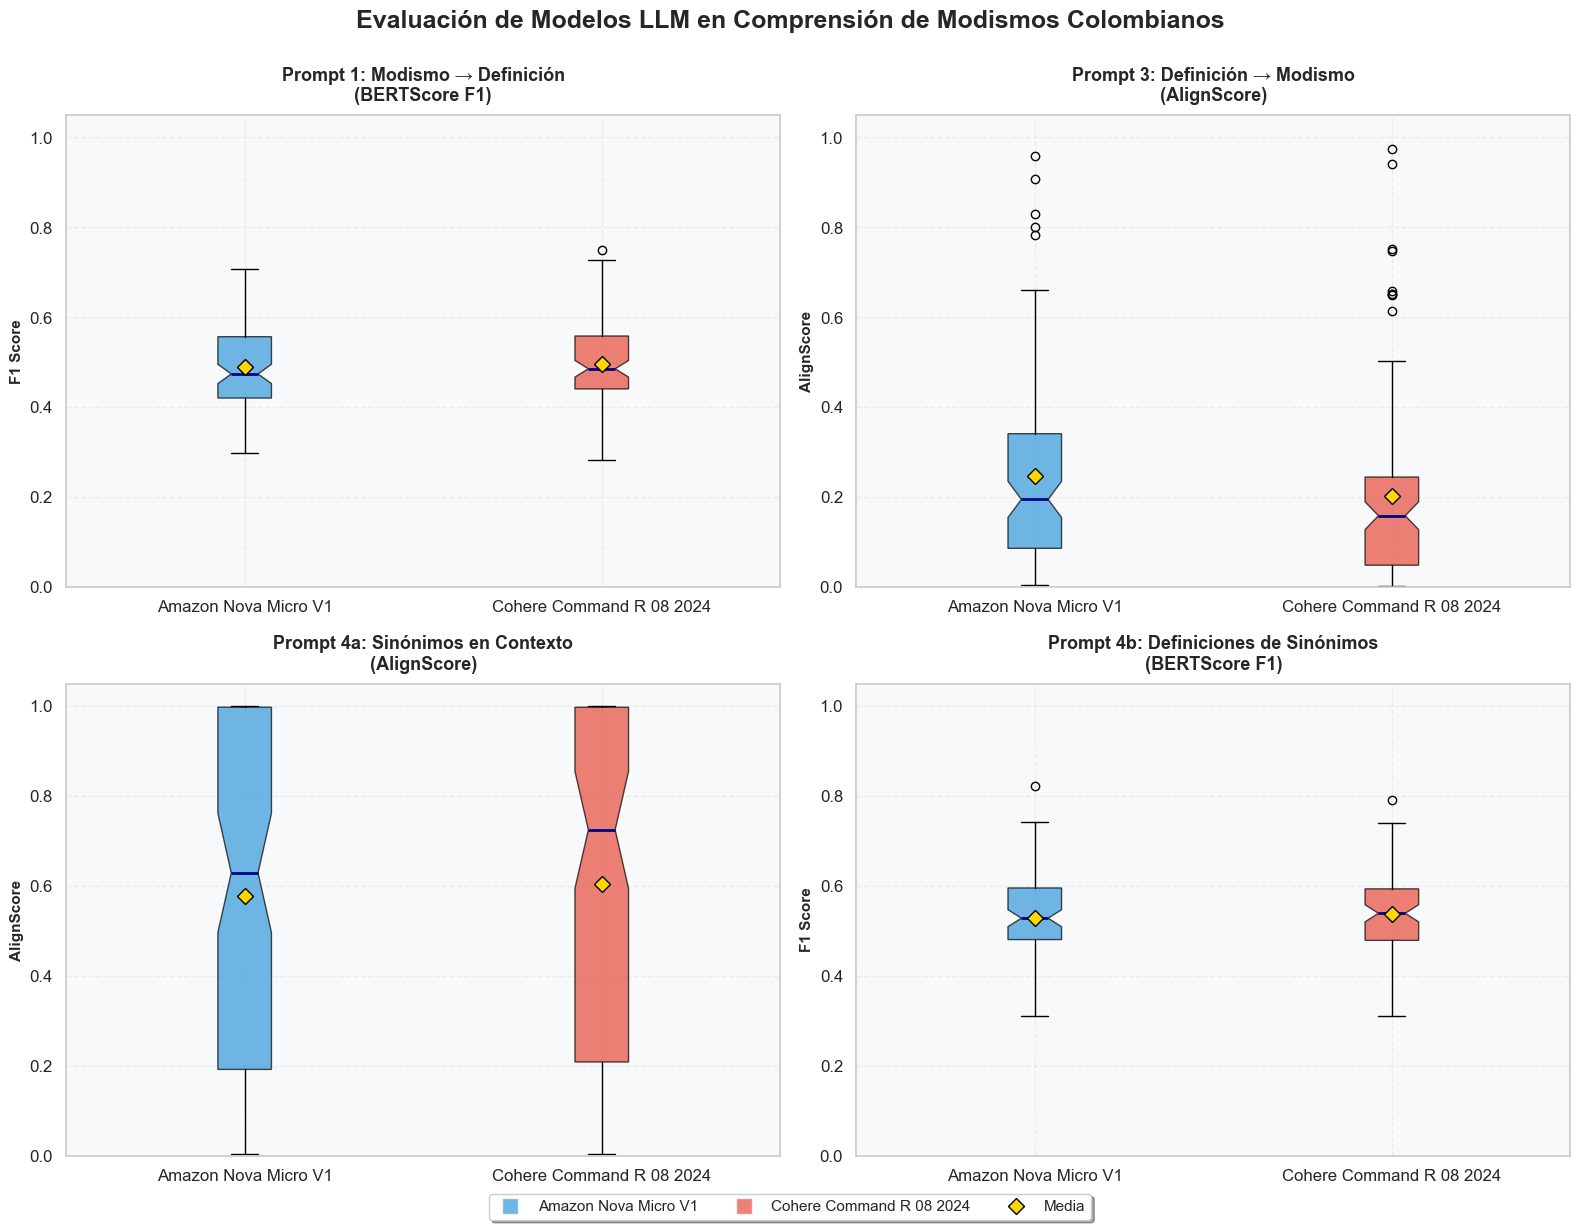

In [9]:
print("="*80)
print("Generando visualizaciones...")
print("="*80)

# Configuración de estilo mejorado
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Colores profesionales y distintivos para cada modelo
colors = {
    MODEL_NAMES[0]: '#3498db',  # Azul moderno
    MODEL_NAMES[1]: '#e74c3c'   # Rojo coral
}

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evaluación de Modelos LLM en Comprensión de Modismos Colombianos', 
             fontsize=18, fontweight='bold', y=0.995)

# ====================================================================
# 1. Prompt 1: BERTScore F1 (Modismo → Definición)
# ====================================================================
ax1 = axes[0, 0]
bp1 = ax1.boxplot(
    [df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].values 
     for model in MODEL_NAMES],
    labels=[name.replace('_', ' ') for name in MODEL_NAMES],
    patch_artist=True,
    notch=True,
    showmeans=True,
    meanprops=dict(marker='D', markerfacecolor='gold', markeredgecolor='black', markersize=8)
)

# Colorear cajas
for patch, model in zip(bp1['boxes'], MODEL_NAMES):
    patch.set_facecolor(colors[model])
    patch.set_alpha(0.7)

# Personalizar medianas
for median in bp1['medians']:
    median.set_color('darkblue')
    median.set_linewidth(2)

ax1.set_title('Prompt 1: Modismo → Definición\n(BERTScore F1)', 
              fontsize=13, fontweight='bold', pad=10)
ax1.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

# ====================================================================
# 2. Prompt 3: AlignScore (Definición → Modismo)
# ====================================================================
ax2 = axes[0, 1]
bp2 = ax2.boxplot(
    [df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].values 
     for model in MODEL_NAMES],
    labels=[name.replace('_', ' ') for name in MODEL_NAMES],
    patch_artist=True,
    notch=True,
    showmeans=True,
    meanprops=dict(marker='D', markerfacecolor='gold', markeredgecolor='black', markersize=8)
)

for patch, model in zip(bp2['boxes'], MODEL_NAMES):
    patch.set_facecolor(colors[model])
    patch.set_alpha(0.7)

for median in bp2['medians']:
    median.set_color('darkblue')
    median.set_linewidth(2)

ax2.set_title('Prompt 3: Definición → Modismo\n(AlignScore)', 
              fontsize=13, fontweight='bold', pad=10)
ax2.set_ylabel('AlignScore', fontsize=11, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

# ====================================================================
# 3. Prompt 4a: AlignScore Sinónimos (Contexto)
# ====================================================================
ax3 = axes[1, 0]
if len(df_resultados_p4a) > 0:
    bp3 = ax3.boxplot(
        [df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].values 
         for model in MODEL_NAMES if len(df_resultados_p4a[df_resultados_p4a['modelo'] == model]) > 0],
        labels=[name.replace('_', ' ') for name in MODEL_NAMES 
                if len(df_resultados_p4a[df_resultados_p4a['modelo'] == name]) > 0],
        patch_artist=True,
        notch=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='gold', markeredgecolor='black', markersize=8)
    )
    
    for patch, model in zip(bp3['boxes'], 
                           [m for m in MODEL_NAMES if len(df_resultados_p4a[df_resultados_p4a['modelo'] == m]) > 0]):
        patch.set_facecolor(colors[model])
        patch.set_alpha(0.7)
    
    for median in bp3['medians']:
        median.set_color('darkblue')
        median.set_linewidth(2)
    
    ax3.set_title('Prompt 4a: Sinónimos en Contexto\n(AlignScore)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax3.set_ylabel('AlignScore', fontsize=11, fontweight='bold')
    ax3.set_ylim([0, 1.05])
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_facecolor('#f8f9fa')
else:
    ax3.text(0.5, 0.5, 'Sin datos disponibles', 
             ha='center', va='center', transform=ax3.transAxes,
             fontsize=14, style='italic')
    ax3.set_title('Prompt 4a: Sinónimos', fontsize=13, fontweight='bold')
    ax3.set_facecolor('#f8f9fa')

# ====================================================================
# 4. Prompt 4b: BERTScore Definiciones de Sinónimos
# ====================================================================
ax4 = axes[1, 1]
if len(df_resultados_p4b) > 0:
    bp4 = ax4.boxplot(
        [df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].values 
         for model in MODEL_NAMES if len(df_resultados_p4b[df_resultados_p4b['modelo'] == model]) > 0],
        labels=[name.replace('_', ' ') for name in MODEL_NAMES 
                if len(df_resultados_p4b[df_resultados_p4b['modelo'] == name]) > 0],
        patch_artist=True,
        notch=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='gold', markeredgecolor='black', markersize=8)
    )
    
    for patch, model in zip(bp4['boxes'], 
                           [m for m in MODEL_NAMES if len(df_resultados_p4b[df_resultados_p4b['modelo'] == m]) > 0]):
        patch.set_facecolor(colors[model])
        patch.set_alpha(0.7)
    
    for median in bp4['medians']:
        median.set_color('darkblue')
        median.set_linewidth(2)
    
    ax4.set_title('Prompt 4b: Definiciones de Sinónimos\n(BERTScore F1)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax4.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax4.set_ylim([0, 1.05])
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_facecolor('#f8f9fa')
else:
    ax4.text(0.5, 0.5, 'Sin datos disponibles', 
             ha='center', va='center', transform=ax4.transAxes,
             fontsize=14, style='italic')
    ax4.set_title('Prompt 4b: Definiciones', fontsize=13, fontweight='bold')
    ax4.set_facecolor('#f8f9fa')

# Ajustar layout
plt.tight_layout()

# Agregar leyenda personalizada
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[MODEL_NAMES[0]], 
               markersize=12, alpha=0.7, label=MODEL_NAMES[0].replace('_', ' ')),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[MODEL_NAMES[1]], 
               markersize=12, alpha=0.7, label=MODEL_NAMES[1].replace('_', ' ')),
    plt.Line2D([0], [0], marker='D', color='gold', markeredgecolor='black', 
               markersize=8, linestyle='None', label='Media')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          bbox_to_anchor=(0.5, -0.02), fontsize=11, frameon=True, fancybox=True, shadow=True)

# Guardar figura
output_fig = os.path.join(OUTPUT_DIR, 'comparacion_modelos_boxplots.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Gráfico guardado en: {output_fig}")
print("="*80)

plt.show()

Generando gráfico de barras comparativo...
✓ Gráfico guardado en: Metricas_Resultados/comparacion_barras.png
✓ Gráfico guardado en: Metricas_Resultados/comparacion_barras.png


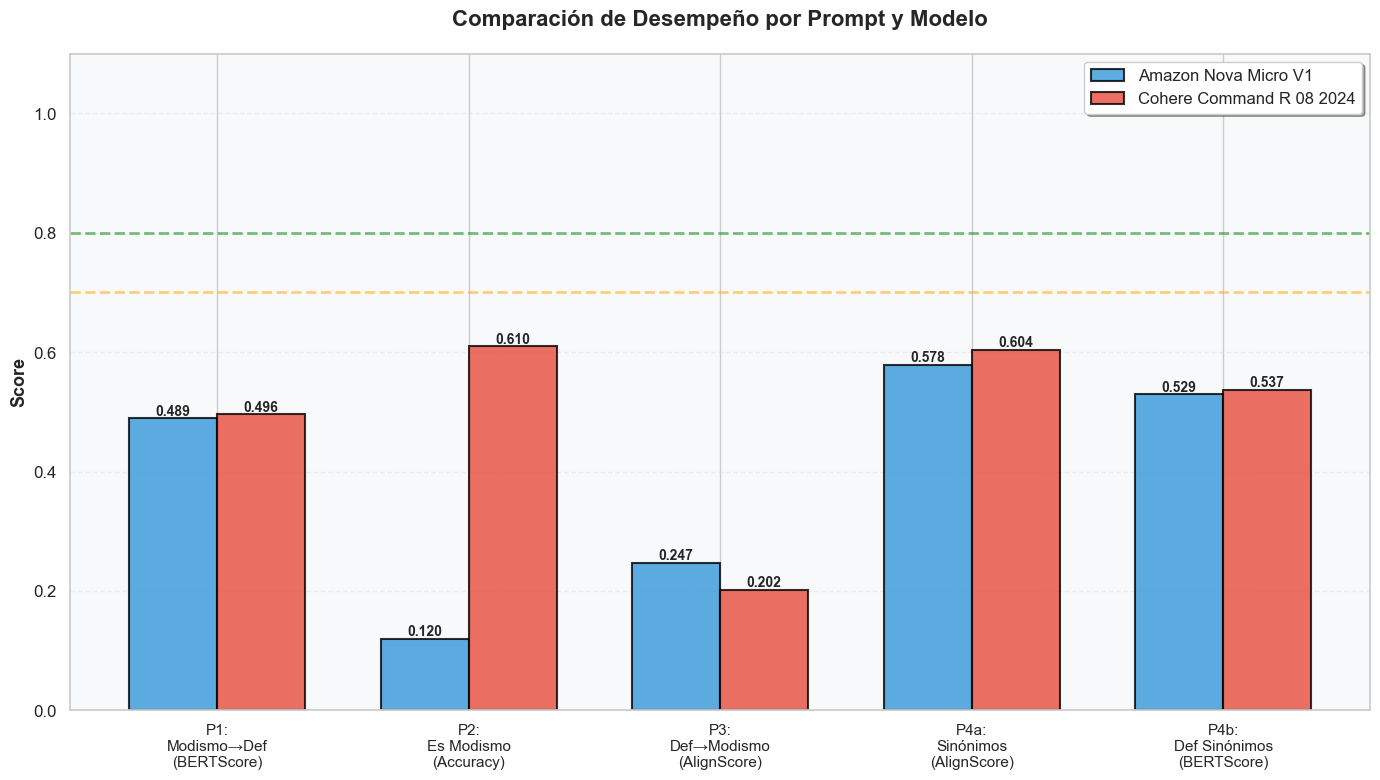

In [10]:
import numpy as np

print("="*80)
print("Generando gráfico de barras comparativo...")
print("="*80)

# Preparar datos para gráfico de barras
prompts = ['P1:\nModismo→Def\n(BERTScore)', 
           'P2:\nEs Modismo\n(Accuracy)', 
           'P3:\nDef→Modismo\n(AlignScore)',
           'P4a:\nSinónimos\n(AlignScore)',
           'P4b:\nDef Sinónimos\n(BERTScore)']

scores_model1 = []
scores_model2 = []

for model in MODEL_NAMES:
    scores = [
        df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean(),
        df_resultados_p2[df_resultados_p2['modelo'] == model]['correcto'].mean(),
        df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean(),
        df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].mean() if len(df_resultados_p4a[df_resultados_p4a['modelo'] == model]) > 0 else 0,
        df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].mean() if len(df_resultados_p4b[df_resultados_p4b['modelo'] == model]) > 0 else 0
    ]
    
    if model == MODEL_NAMES[0]:
        scores_model1 = scores
    else:
        scores_model2 = scores

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(prompts))
width = 0.35

# Barras para cada modelo
bars1 = ax.bar(x - width/2, scores_model1, width, 
               label=MODEL_NAMES[0].replace('_', ' '),
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, scores_model2, width,
               label=MODEL_NAMES[1].replace('_', ' '),
               color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

# Agregar valores sobre las barras
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

add_values_on_bars(bars1)
add_values_on_bars(bars2)

# Personalización
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Comparación de Desempeño por Prompt y Modelo', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(prompts, fontsize=11)
ax.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.set_facecolor('#f8f9fa')

# Línea de referencia
ax.axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Umbral "Muy Bueno" (0.80)')
ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Umbral "Bueno" (0.70)')

plt.tight_layout()

# Guardar
output_fig = os.path.join(OUTPUT_DIR, 'comparacion_barras.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Gráfico guardado en: {output_fig}")
print("="*80)

plt.show()

## 8. Tabla Consolidada de Resultados

In [11]:
print("\n")
print("="*100)
print("TABLA CONSOLIDADA DE RESULTADOS")
print("="*100)
print()

resultados = []

for model in MODEL_NAMES:
    # Prompt 1: BERTScore F1
    p1_f1 = df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean()
    p1_std = df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].std()
    
    # Prompt 2: Accuracy
    p2_acc = df_resultados_p2[df_resultados_p2['modelo'] == model]['correcto'].mean()
    
    # Prompt 3: AlignScore
    p3_align = df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean()
    p3_std = df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].std()
    
    # Prompt 4a: AlignScore
    if len(df_resultados_p4a) > 0:
        p4a_data = df_resultados_p4a[df_resultados_p4a['modelo'] == model]
        p4a_align = p4a_data['align_score'].mean() if len(p4a_data) > 0 else 0
        p4a_std = p4a_data['align_score'].std() if len(p4a_data) > 0 else 0
    else:
        p4a_align = 0
        p4a_std = 0
    
    # Prompt 4b: BERTScore F1
    if len(df_resultados_p4b) > 0:
        p4b_data = df_resultados_p4b[df_resultados_p4b['modelo'] == model]
        p4b_f1 = p4b_data['f1_score'].mean() if len(p4b_data) > 0 else 0
        p4b_std = p4b_data['f1_score'].std() if len(p4b_data) > 0 else 0
    else:
        p4b_f1 = 0
        p4b_std = 0
    
    resultados.append({
        'Modelo': model.replace('_', ' '),
        'P1: BERTScore F1\n(Modismo→Def)': f"{p1_f1:.4f} (±{p1_std:.3f})",
        'P2: Accuracy\n(Es Modismo)': f"{p2_acc:.4f}",
        'P3: AlignScore\n(Def→Modismo)': f"{p3_align:.4f} (±{p3_std:.3f})",
        'P4a: AlignScore\n(Sinónimos)': f"{p4a_align:.4f} (±{p4a_std:.3f})" if p4a_align > 0 else "N/A",
        'P4b: BERTScore\n(Def Sinónimos)': f"{p4b_f1:.4f} (±{p4b_std:.3f})" if p4b_f1 > 0 else "N/A"
    })

df_tabla = pd.DataFrame(resultados)

# Mostrar tabla con formato mejorado
print(df_tabla.to_string(index=False))
print()
print("="*100)
print()
print("INTERPRETACIÓN DE LAS MÉTRICAS:")
print("   • BERTScore (0-1): Similitud semántica. Más alto = mejor comprensión del significado")
print("   • AlignScore (0-1): Consistencia factual. Más alto = respuestas más consistentes")
print("   • Accuracy (0-1): Exactitud en clasificación. Más alto = mejor identificación")
print()
print("   Valores entre paréntesis (±X) indican la desviación estándar")
print()

# Guardar CSV
output_file = os.path.join(OUTPUT_DIR, 'resultados_consolidados.csv')
df_tabla.to_csv(output_file, index=False)
print(f"✓ Guardado en: {output_file}")
print("="*100)
print()



TABLA CONSOLIDADA DE RESULTADOS

                  Modelo P1: BERTScore F1\n(Modismo→Def) P2: Accuracy\n(Es Modismo) P3: AlignScore\n(Def→Modismo) P4a: AlignScore\n(Sinónimos) P4b: BERTScore\n(Def Sinónimos)
    Amazon Nova Micro V1                 0.4888 (±0.092)                     0.1200               0.2471 (±0.219)              0.5785 (±0.378)                 0.5294 (±0.093)
Cohere Command R 08 2024                 0.4958 (±0.098)                     0.6100               0.2019 (±0.211)              0.6040 (±0.381)                 0.5372 (±0.092)


INTERPRETACIÓN DE LAS MÉTRICAS:
   • BERTScore (0-1): Similitud semántica. Más alto = mejor comprensión del significado
   • AlignScore (0-1): Consistencia factual. Más alto = respuestas más consistentes
   • Accuracy (0-1): Exactitud en clasificación. Más alto = mejor identificación

   Valores entre paréntesis (±X) indican la desviación estándar

✓ Guardado en: Metricas_Resultados/resultados_consolidados.csv



Generando mapa de calor (heatmap) de resultados...
✓ Heatmap guardado en: Metricas_Resultados/heatmap_resultados.png
✓ Heatmap guardado en: Metricas_Resultados/heatmap_resultados.png


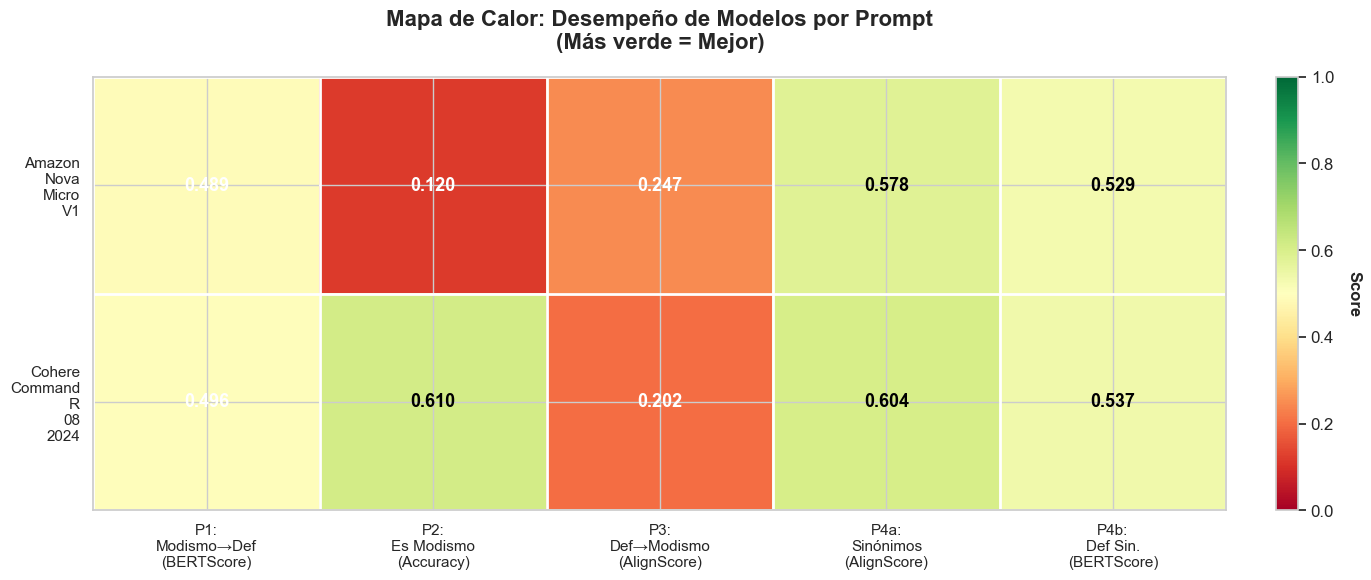

In [12]:
print("="*80)
print("Generando mapa de calor (heatmap) de resultados...")
print("="*80)

# Preparar datos para heatmap
heatmap_data = []
row_labels = []

for model in MODEL_NAMES:
    row = [
        df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean(),
        df_resultados_p2[df_resultados_p2['modelo'] == model]['correcto'].mean(),
        df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean(),
        df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].mean() if len(df_resultados_p4a[df_resultados_p4a['modelo'] == model]) > 0 else 0,
        df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].mean() if len(df_resultados_p4b[df_resultados_p4b['modelo'] == model]) > 0 else 0
    ]
    heatmap_data.append(row)
    row_labels.append(model.replace('_', '\n'))

col_labels = ['P1:\nModismo→Def\n(BERTScore)', 
              'P2:\nEs Modismo\n(Accuracy)', 
              'P3:\nDef→Modismo\n(AlignScore)',
              'P4a:\nSinónimos\n(AlignScore)',
              'P4b:\nDef Sin.\n(BERTScore)']

# Crear heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Usar colormap más atractivo
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Configurar ejes
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, fontsize=11)
ax.set_yticklabels(row_labels, fontsize=11)

# Rotar etiquetas del eje x
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Agregar valores en las celdas
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        value = heatmap_data[i][j]
        # Elegir color de texto según el fondo
        text_color = 'white' if value < 0.5 else 'black'
        text = ax.text(j, i, f'{value:.3f}',
                      ha="center", va="center", 
                      color=text_color, fontsize=13, fontweight='bold')

# Título y colorbar
ax.set_title('Mapa de Calor: Desempeño de Modelos por Prompt\n(Más verde = Mejor)', 
             fontsize=16, fontweight='bold', pad=20)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Score', rotation=270, labelpad=20, fontsize=12, fontweight='bold')

# Agregar líneas de separación
for i in range(len(row_labels) + 1):
    ax.axhline(i - 0.5, color='white', linewidth=2)
for j in range(len(col_labels) + 1):
    ax.axvline(j - 0.5, color='white', linewidth=2)

plt.tight_layout()

# Guardar
output_fig = os.path.join(OUTPUT_DIR, 'heatmap_resultados.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Heatmap guardado en: {output_fig}")
print("="*80)

plt.show()

Generando gráfico de líneas superpuestas...
✓ Gráfico de líneas guardado en: Metricas_Resultados/lineas_tendencia.png
✓ Gráfico de líneas guardado en: Metricas_Resultados/lineas_tendencia.png


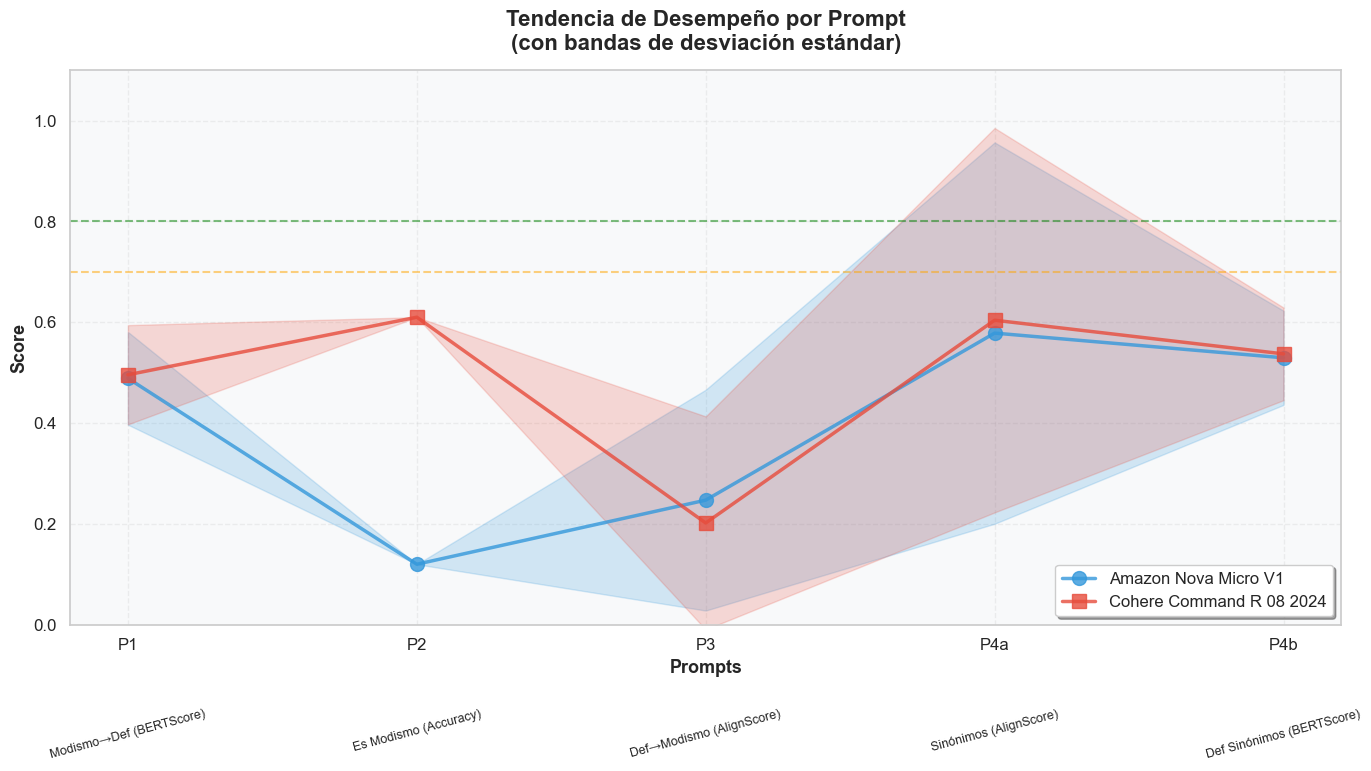

In [13]:
print("="*80)
print("Generando gráfico de líneas superpuestas...")
print("="*80)

# Gráfico de líneas para ver tendencias entre prompts
fig, ax = plt.subplots(figsize=(14, 8))

prompts_short = ['P1', 'P2', 'P3', 'P4a', 'P4b']
x_pos = np.arange(len(prompts_short))

for model, color, marker in zip(MODEL_NAMES, ['#3498db', '#e74c3c'], ['o', 's']):
    scores = [
        df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean(),
        df_resultados_p2[df_resultados_p2['modelo'] == model]['correcto'].mean(),
        df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean(),
        df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].mean() if len(df_resultados_p4a[df_resultados_p4a['modelo'] == model]) > 0 else 0,
        df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].mean() if len(df_resultados_p4b[df_resultados_p4b['modelo'] == model]) > 0 else 0
    ]
    
    # Calcular desviaciones estándar
    stds = [
        df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].std(),
        0,  # Accuracy no tiene std en este contexto
        df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].std(),
        df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].std() if len(df_resultados_p4a[df_resultados_p4a['modelo'] == model]) > 0 else 0,
        df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].std() if len(df_resultados_p4b[df_resultados_p4b['modelo'] == model]) > 0 else 0
    ]
    
    ax.plot(x_pos, scores, marker=marker, markersize=10, linewidth=2.5, 
            label=model.replace('_', ' '), color=color, alpha=0.8)
    ax.fill_between(x_pos, np.array(scores) - np.array(stds), 
                    np.array(scores) + np.array(stds), 
                    alpha=0.2, color=color)

# Personalización
ax.set_xlabel('Prompts', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Tendencia de Desempeño por Prompt\n(con bandas de desviación estándar)', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(prompts_short, fontsize=12)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0.8, color='green', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_facecolor('#f8f9fa')

ax.legend(fontsize=12, loc='lower right', frameon=True, fancybox=True, shadow=True)

# Anotar prompts completos
prompt_descriptions = [
    'Modismo→Def (BERTScore)',
    'Es Modismo (Accuracy)',
    'Def→Modismo (AlignScore)',
    'Sinónimos (AlignScore)',
    'Def Sinónimos (BERTScore)'
]

for i, desc in enumerate(prompt_descriptions):
    ax.text(i, -0.15, desc, ha='center', va='top', fontsize=9, 
            rotation=15, transform=ax.get_xaxis_transform())

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'lineas_tendencia.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Gráfico de líneas guardado en: {output_fig}")
print("="*80)

plt.show()

Generando gráfico radar (spider chart) para comparación multidimensional...
✓ Radar chart guardado en: Metricas_Resultados/radar_chart.png
✓ Radar chart guardado en: Metricas_Resultados/radar_chart.png


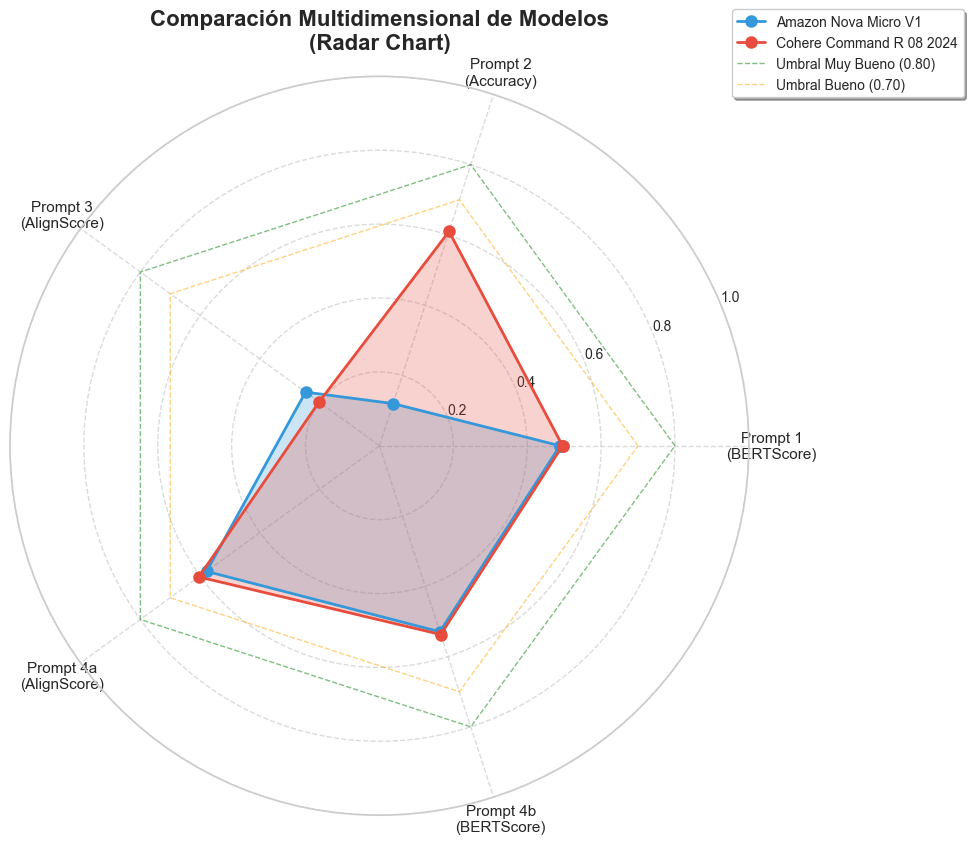

In [14]:
print("="*80)
print("Generando gráfico radar (spider chart) para comparación multidimensional...")
print("="*80)

# Preparar datos para radar chart
categories = ['Prompt 1\n(BERTScore)', 
              'Prompt 2\n(Accuracy)', 
              'Prompt 3\n(AlignScore)',
              'Prompt 4a\n(AlignScore)',
              'Prompt 4b\n(BERTScore)']

scores_by_model = {}
for model in MODEL_NAMES:
    scores_by_model[model] = [
        df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean(),
        df_resultados_p2[df_resultados_p2['modelo'] == model]['correcto'].mean(),
        df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean(),
        df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].mean() if len(df_resultados_p4a[df_resultados_p4a['modelo'] == model]) > 0 else 0,
        df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].mean() if len(df_resultados_p4b[df_resultados_p4b['modelo'] == model]) > 0 else 0
    ]

# Número de variables
num_vars = len(categories)

# Calcular ángulos para cada eje
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Colores para cada modelo
colors_radar = ['#3498db', '#e74c3c']
alphas = [0.25, 0.25]

# Dibujar cada modelo
for idx, (model, color, alpha) in enumerate(zip(MODEL_NAMES, colors_radar, alphas)):
    values = scores_by_model[model]
    values += values[:1]  # Cerrar el polígono
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model.replace('_', ' '), 
            color=color, markersize=8)
    ax.fill(angles, values, alpha=alpha, color=color)

# Configurar el gráfico
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Añadir líneas de referencia
ax.plot(angles, [0.8] * len(angles), 'g--', linewidth=1, alpha=0.5, label='Umbral Muy Bueno (0.80)')
ax.plot(angles, [0.7] * len(angles), color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Umbral Bueno (0.70)')

plt.title('Comparación Multidimensional de Modelos\n(Radar Chart)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'radar_chart.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Radar chart guardado en: {output_fig}")
print("="*80)

plt.show()

## 9. Visualizaciones Avanzadas

### Análisis de distribuciones, comparaciones superpuestas y correlaciones

In [16]:
print("="*80)
print("Extrayendo embeddings de BERT para visualización...")
print("="*80)

from transformers import AutoModel, AutoTokenizer
import torch

# Usar el mismo modelo BERT que BERTScore
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
print(f"Cargando modelo: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()

def get_embeddings(texts, batch_size=16):
    """Extrae embeddings del token [CLS] usando BERT"""
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenizar
            inputs = tokenizer(batch_texts, return_tensors="pt", 
                             truncation=True, max_length=512, 
                             padding=True)
            
            # Obtener embeddings
            outputs = bert_model(**inputs)
            
            # Usar embedding del token [CLS] (primer token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

# Preparar datos para embeddings
print("\nPreparando datos...")
all_texts = []
all_labels = []
all_modismos = []
all_scores = []

# 1. Definiciones generadas por cada modelo
for model_name_llm in MODEL_NAMES:
    df_model = df_resultados_p1[df_resultados_p1['modelo'] == model_name_llm]
    
    for idx, row in df_model.iterrows():
        all_texts.append(row['definicion_generada'])
        all_labels.append(model_name_llm)
        all_modismos.append(row['modismo'])
        all_scores.append(row['f1_score'])

# 2. Definiciones reales (ground truth)
for idx, row in df_p1.iterrows():
    all_texts.append(row['definicion_real'])
    all_labels.append('Ground Truth')
    all_modismos.append(row['modismo'])
    all_scores.append(1.0)  # Score perfecto para ground truth

print(f"Total de textos a procesar: {len(all_texts)}")
print(f"   - {MODEL_NAMES[0]}: {all_labels.count(MODEL_NAMES[0])}")
print(f"   - {MODEL_NAMES[1]}: {all_labels.count(MODEL_NAMES[1])}")
print(f"   - Ground Truth: {all_labels.count('Ground Truth')}")

# Extraer embeddings
print("\nExtrayendo embeddings (esto puede tomar un momento)...")
embeddings = get_embeddings(all_texts)

print(f"✓ Embeddings extraídos: shape = {embeddings.shape}")
print("="*80)

Extrayendo embeddings de BERT para visualización...
Cargando modelo: dccuchile/bert-base-spanish-wwm-uncased

Preparando datos...
Total de textos a procesar: 300
   - Amazon_Nova_Micro_V1: 100
   - Cohere_Command_R_08_2024: 100
   - Ground Truth: 100

Extrayendo embeddings (esto puede tomar un momento)...

Preparando datos...
Total de textos a procesar: 300
   - Amazon_Nova_Micro_V1: 100
   - Cohere_Command_R_08_2024: 100
   - Ground Truth: 100

Extrayendo embeddings (esto puede tomar un momento)...
✓ Embeddings extraídos: shape = (300, 768)
✓ Embeddings extraídos: shape = (300, 768)


In [17]:
print("="*80)
print("Reduciendo dimensionalidad con t-SNE y UMAP...")
print("="*80)

from sklearn.manifold import TSNE
import umap

# t-SNE
print("\nAplicando t-SNE...")
tsne = TSNE(n_components=2, 
           random_state=42, 
           perplexity=30,
           max_iter=1000,
           learning_rate=200,
           verbose=1)

coords_tsne = tsne.fit_transform(embeddings)
print(f"✓ t-SNE completado: shape = {coords_tsne.shape}")

# UMAP (alternativa más rápida y preserva estructura global)
print("\nAplicando UMAP...")
reducer = umap.UMAP(n_components=2, 
                   random_state=42,
                   n_neighbors=15,
                   min_dist=0.1,
                   metric='cosine',
                   verbose=True)
coords_umap = reducer.fit_transform(embeddings)
print(f"✓ UMAP completado: shape = {coords_umap.shape}")

print("="*80)

Reduciendo dimensionalidad con t-SNE y UMAP...

Aplicando t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 5.775480


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.579285
[t-SNE] KL divergence after 1000 iterations: 0.846103
✓ t-SNE completado: shape = (300, 2)

Aplicando UMAP...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Mon Nov 10 11:25:19 2025 Construct fuzzy simplicial set
Mon Nov 10 11:25:19 2025 Finding Nearest Neighbors
[t-SNE] KL divergence after 1000 iterations: 0.846103
✓ t-SNE completado: shape = (300, 2)

Aplicando UMAP...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Mon Nov 10 11:25:19 2025 Construct fuzzy simplicial set
Mon Nov 10 11:25:19 2025 Finding Nearest Neighbors
Mon Nov 10 11:25:20 2025 Finished Nearest Neighbor Search
Mon Nov 10 11:25:20 2025 Finished Nearest Neighbor Search
Mon Nov 10 11:25:21 2025 Construct embedding
Mon Nov 10 11:25:21 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Nov 10 11:25:21 2025 Finished embedding
✓ UMAP completado: shape = (300, 2)


Análisis detallado: Identificando outliers en el espacio de embeddings...
✓ Análisis de outliers guardado en: Metricas_Resultados/outliers_analysis.png
✓ Análisis de outliers guardado en: Metricas_Resultados/outliers_analysis.png


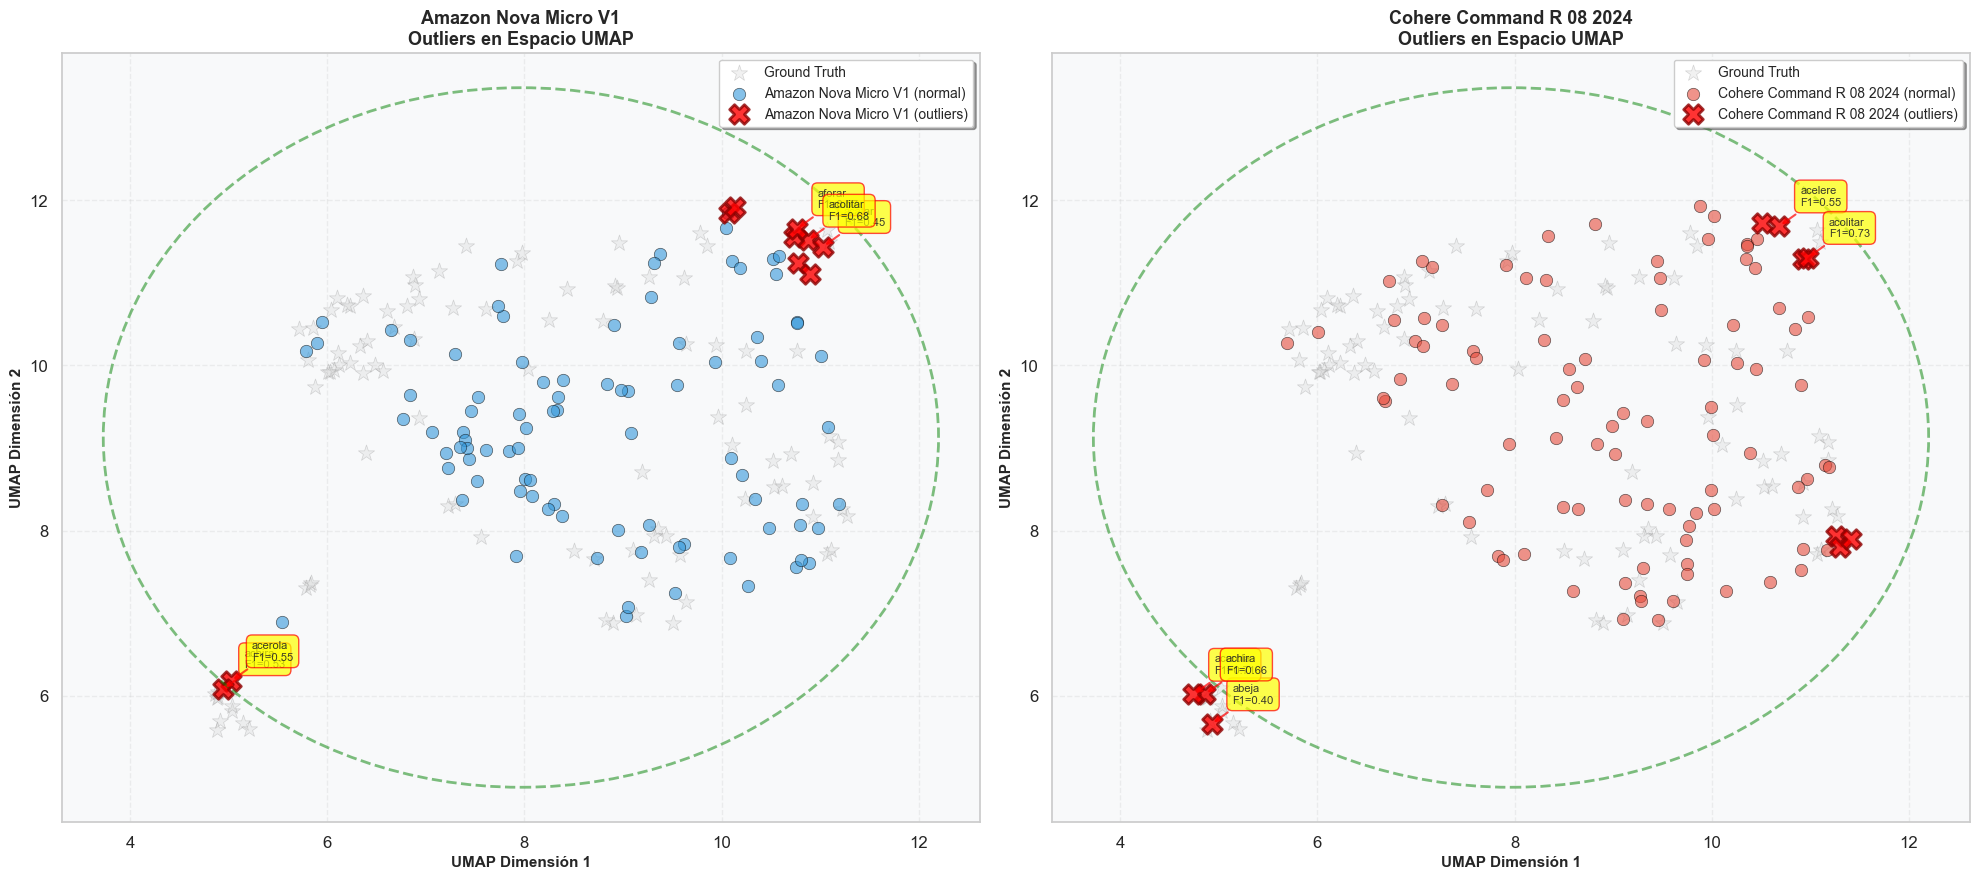


DETALLE DE OUTLIERS (Casos más problemáticos):

Amazon Nova Micro V1 - Top 5 Outliers:
--------------------------------------------------------------------------------

1. 'achira'
   • F1 Score: 0.532
   • Distancia a GT: 4.29
   • Definición Real:
     Planta herbácea, de hasta 3 m de altura, con hojas grandes, flores amarillas, naranjas o rojas; sus hojas sirven para envolver algunos alimentos y de sus rizomas se extrae almidón comestible.
   • Definición Generada:
     Planta medicinal tradicionalmente utilizada para aliviar dolores articulares.

2. 'acerola'
   • F1 Score: 0.552
   • Distancia a GT: 4.16
   • Definición Real:
     Arbusto de hasta 6 m de altura, corteza obscura y denso ramaje, hojas simples de color verde obscuro, flores de color lila, rosado y blanco, su fruto es redondo y comestible.
   • Definición Generada:
     Fruta pequeña y ácida, rica en vitamina C, nativa de América tropical.

3. 'acatar'
   • F1 Score: 0.453
   • Distancia a GT: 3.84
   • Definición Re

In [18]:
print("="*80)
print("Análisis detallado: Identificando outliers en el espacio de embeddings...")
print("="*80)

from sklearn.neighbors import NearestNeighbors

# Convertir listas a arrays numpy para indexación eficiente
all_labels_array = np.array(all_labels)
all_scores_array = np.array(all_scores)

# Usar UMAP para análisis (preserva mejor la estructura global)
# Identificar definiciones generadas más alejadas de Ground Truth

# Obtener coordenadas de Ground Truth
mask_gt = all_labels_array == 'Ground Truth'
coords_gt = coords_umap[mask_gt]

# Para cada modelo, encontrar las definiciones más alejadas de GT
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for idx, (model, color) in enumerate(zip(MODEL_NAMES, ['#3498db', '#e74c3c'])):
    ax = axes[idx]
    
    # Obtener coordenadas del modelo
    mask_model = all_labels_array == model
    coords_model = coords_umap[mask_model]
    
    # Calcular distancia de cada punto del modelo al centroide de GT
    gt_centroid = coords_gt.mean(axis=0)
    distances = np.linalg.norm(coords_model - gt_centroid, axis=1)
    
    # Obtener índices en el array original
    model_indices = np.where(mask_model)[0]
    
    # Identificar los 10 más alejados (outliers)
    outlier_indices_rel = np.argsort(distances)[-10:]
    outlier_indices = model_indices[outlier_indices_rel]
    
    # Graficar todos los puntos
    # Ground Truth
    ax.scatter(coords_gt[:, 0], coords_gt[:, 1],
              c='lightgray', s=150, alpha=0.3, marker='*',
              edgecolors='gray', linewidth=0.5, label='Ground Truth')
    
    # Puntos del modelo (normal)
    normal_mask = np.ones(len(coords_model), dtype=bool)
    normal_mask[outlier_indices_rel] = False
    ax.scatter(coords_model[normal_mask, 0], coords_model[normal_mask, 1],
              c=color, s=80, alpha=0.6,
              edgecolors='black', linewidth=0.5,
              label=f'{model.replace("_", " ")} (normal)')
    
    # Outliers (destacados)
    ax.scatter(coords_model[outlier_indices_rel, 0], coords_model[outlier_indices_rel, 1],
              c='red', s=200, alpha=0.8, marker='X',
              edgecolors='darkred', linewidth=2,
              label=f'{model.replace("_", " ")} (outliers)')
    
    # Anotar los 5 outliers más extremos
    for i in range(min(5, len(outlier_indices_rel))):
        idx_rel = outlier_indices_rel[-(i+1)]
        idx_abs = outlier_indices[-(i+1)]
        
        modismo = all_modismos[idx_abs]
        score = all_scores[idx_abs]
        
        if len(modismo) > 20:
            label = modismo[:17] + '...'
        else:
            label = modismo
        
        ax.annotate(f'{label}\nF1={score:.2f}',
                   (coords_model[idx_rel, 0], coords_model[idx_rel, 1]),
                   xytext=(15, 15), textcoords='offset points',
                   fontsize=8, alpha=0.9,
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                           edgecolor='red', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', lw=1.5, color='red', alpha=0.7))
    
    ax.set_title(f'{model.replace("_", " ")}\nOutliers en Espacio UMAP', 
                fontsize=13, fontweight='bold')
    ax.set_xlabel('UMAP Dimensión 1', fontsize=11, fontweight='bold')
    ax.set_ylabel('UMAP Dimensión 2', fontsize=11, fontweight='bold')
    ax.legend(fontsize=10, loc='best', frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    # Círculo alrededor del centroide de GT
    circle = plt.Circle(gt_centroid, 
                       np.percentile(np.linalg.norm(coords_gt - gt_centroid, axis=1), 90),
                       color='green', fill=False, linestyle='--', linewidth=2, alpha=0.5,
                       label='90% GT radius')
    ax.add_patch(circle)

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'outliers_analysis.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Análisis de outliers guardado en: {output_fig}")

plt.show()

# Listar los outliers con detalles
print("\nDETALLE DE OUTLIERS (Casos más problemáticos):")
print("="*80)

for model in MODEL_NAMES:
    mask_model = all_labels_array == model
    coords_model = coords_umap[mask_model]
    model_indices = np.where(mask_model)[0]
    
    gt_centroid = coords_gt.mean(axis=0)
    distances = np.linalg.norm(coords_model - gt_centroid, axis=1)
    
    outlier_indices_rel = np.argsort(distances)[-5:]
    outlier_indices = model_indices[outlier_indices_rel]
    
    print(f"\n{model.replace('_', ' ')} - Top 5 Outliers:")
    print("-"*80)
    
    for rank, idx in enumerate(outlier_indices[::-1], 1):
        modismo = all_modismos[idx]
        score = all_scores[idx]
        distance = distances[outlier_indices_rel[-(rank)]]
        
        # Buscar definiciones en el dataframe original
        df_detail = df_resultados_p1[
            (df_resultados_p1['modismo'] == modismo) & 
            (df_resultados_p1['modelo'] == model)
        ]
        
        if not df_detail.empty:
            row = df_detail.iloc[0]
            print(f"\n{rank}. '{modismo}'")
            print(f"   • F1 Score: {score:.3f}")
            print(f"   • Distancia a GT: {distance:.2f}")
            print(f"   • Definición Real:")
            print(f"     {row['definicion_real']}")
            print(f"   • Definición Generada:")
            print(f"     {row['definicion_generada']}")

print("\n" + "="*80)
print("\nINTERPRETACIÓN:")
print("   • Outliers = Definiciones semánticamente muy diferentes del ground truth")
print("   • F1 bajo + distancia alta = Definición incorrecta o muy incompleta")
print("   • Estos casos requieren atención especial para mejorar el modelo")
print("="*80)

Visualizando espacio de embeddings (t-SNE y UMAP)...
✓ Visualización guardada en: Metricas_Resultados/tsne_umap_embeddings.png
✓ Visualización guardada en: Metricas_Resultados/tsne_umap_embeddings.png


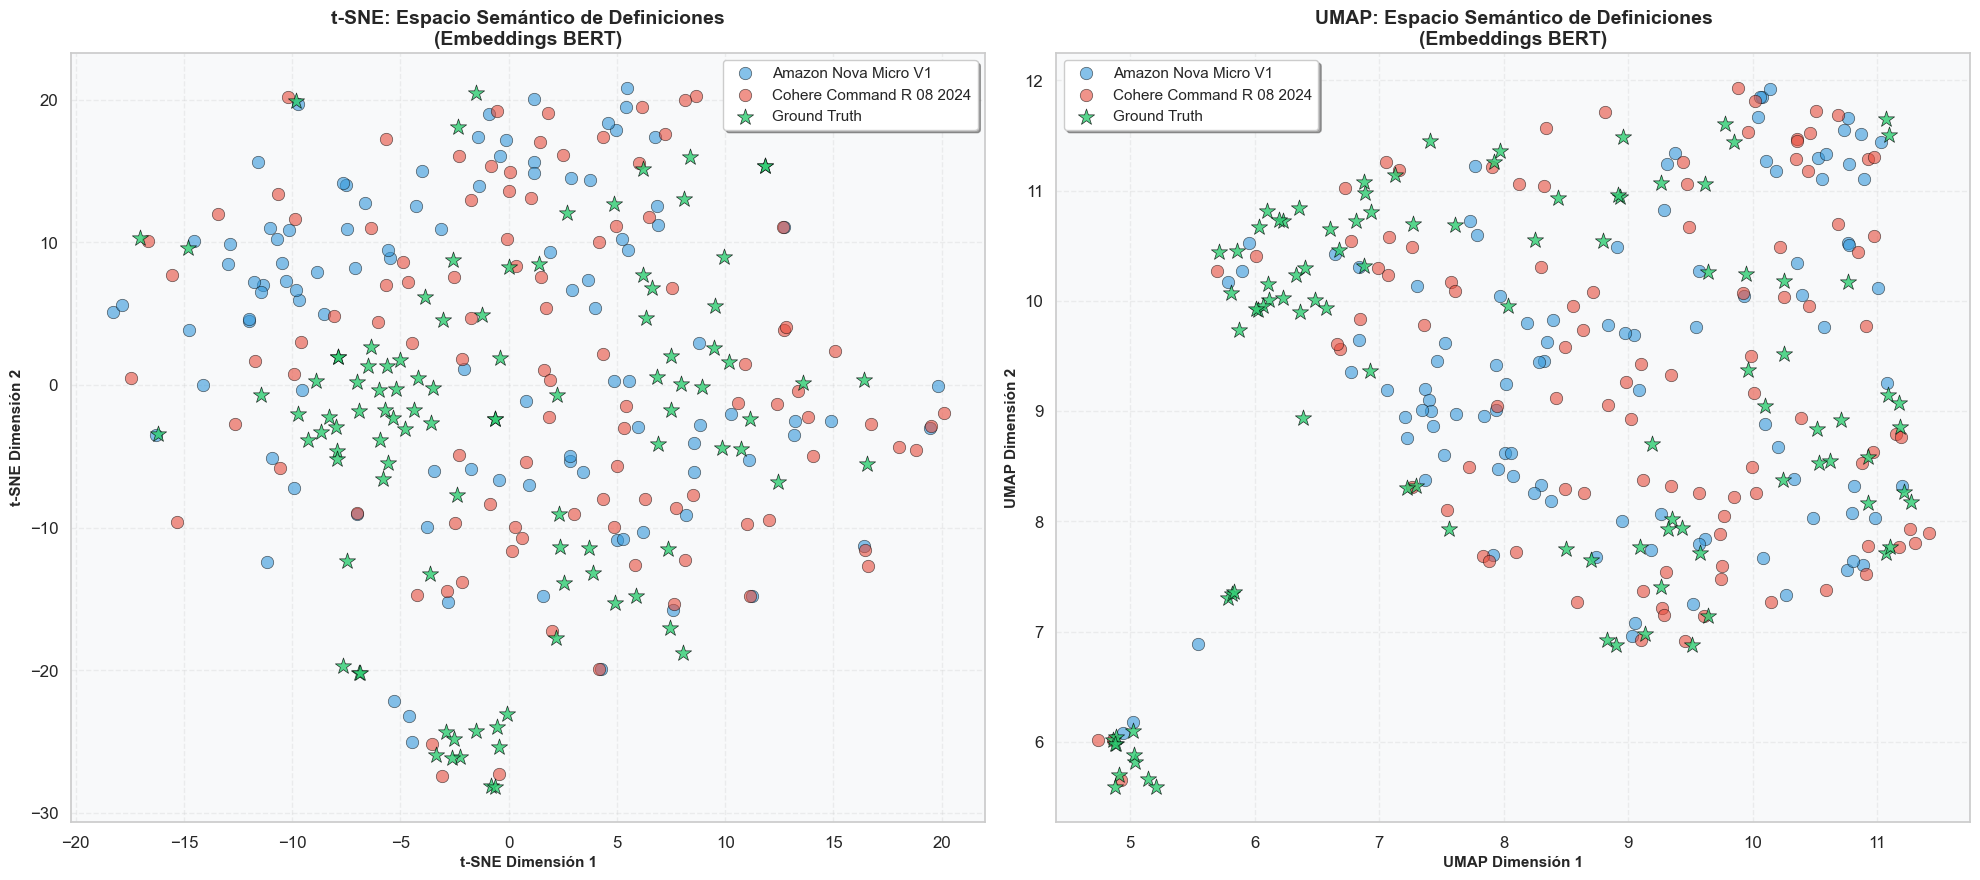


ANÁLISIS DE SEPARACIÓN:
--------------------------------------------------------------------------------

t-SNE:
   • Distancia Amazon Nova Micro V1 ↔ Ground Truth: 6.69
     → Dispersión interna: 9.83
   • Distancia Cohere Command R 08 2024 ↔ Ground Truth: 4.87
     → Dispersión interna: 10.05

UMAP:
   • Distancia Amazon Nova Micro V1 ↔ Ground Truth: 0.95
     → Dispersión interna: 1.47
   • Distancia Cohere Command R 08 2024 ↔ Ground Truth: 1.10
     → Dispersión interna: 1.57

INTERPRETACIÓN:
   • Menor distancia a Ground Truth = Mejor captura del significado semántico
   • Menor dispersión interna = Más consistente en las generaciones


In [19]:
print("="*80)
print("Visualizando espacio de embeddings (t-SNE y UMAP)...")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Colores para cada grupo
colors_map = {
    MODEL_NAMES[0]: '#3498db',
    MODEL_NAMES[1]: '#e74c3c',
    'Ground Truth': '#2ecc71'
}

# Crear arrays para facilitar indexación
all_labels_array = np.array(all_labels)
all_scores_array = np.array(all_scores)

# ====================================================================
# 1. t-SNE
# ====================================================================
ax1 = axes[0]

for label in sorted(set(all_labels)):
    mask = all_labels_array == label
    
    # Diferentes tamaños según el grupo
    size = 150 if label == 'Ground Truth' else 80
    marker = '*' if label == 'Ground Truth' else 'o'
    alpha = 0.8 if label == 'Ground Truth' else 0.6
    
    scatter = ax1.scatter(coords_tsne[mask, 0], coords_tsne[mask, 1],
                         label=label.replace('_', ' '),
                         color=colors_map[label],
                         s=size,
                         alpha=alpha,
                         edgecolors='black',
                         linewidth=0.5,
                         marker=marker)

ax1.set_title('t-SNE: Espacio Semántico de Definiciones\n(Embeddings BERT)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dimensión 1', fontsize=11, fontweight='bold')
ax1.set_ylabel('t-SNE Dimensión 2', fontsize=11, fontweight='bold')
ax1.legend(fontsize=11, loc='best', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

# ====================================================================
# 2. UMAP
# ====================================================================
ax2 = axes[1]

for label in sorted(set(all_labels)):
    mask = all_labels_array == label
    
    size = 150 if label == 'Ground Truth' else 80
    marker = '*' if label == 'Ground Truth' else 'o'
    alpha = 0.8 if label == 'Ground Truth' else 0.6
    
    scatter = ax2.scatter(coords_umap[mask, 0], coords_umap[mask, 1],
                         label=label.replace('_', ' '),
                         color=colors_map[label],
                         s=size,
                         alpha=alpha,
                         edgecolors='black',
                         linewidth=0.5,
                         marker=marker)

ax2.set_title('UMAP: Espacio Semántico de Definiciones\n(Embeddings BERT)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP Dimensión 1', fontsize=11, fontweight='bold')
ax2.set_ylabel('UMAP Dimensión 2', fontsize=11, fontweight='bold')
ax2.legend(fontsize=11, loc='best', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'tsne_umap_embeddings.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Visualización guardada en: {output_fig}")
print("="*80)

plt.show()

# Análisis de separación de clusters
print("\nANÁLISIS DE SEPARACIÓN:")
print("-"*80)

for method_name, coords in [('t-SNE', coords_tsne), ('UMAP', coords_umap)]:
    print(f"\n{method_name}:")
    
    # Calcular centroides por grupo
    centroids = {}
    for label in set(all_labels):
        mask = all_labels_array == label
        centroids[label] = coords[mask].mean(axis=0)
    
    # Calcular distancias entre centroides
    gt_centroid = centroids['Ground Truth']
    for model in MODEL_NAMES:
        model_centroid = centroids[model]
        distance = np.linalg.norm(gt_centroid - model_centroid)
        print(f"   • Distancia {model.replace('_', ' ')} ↔ Ground Truth: {distance:.2f}")
        
        # Dispersión dentro del cluster
        mask = all_labels_array == model
        dispersion = np.std(coords[mask], axis=0).mean()
        print(f"     → Dispersión interna: {dispersion:.2f}")

print("\nINTERPRETACIÓN:")
print("   • Menor distancia a Ground Truth = Mejor captura del significado semántico")
print("   • Menor dispersión interna = Más consistente en las generaciones")
print("="*80)

Visualización coloreada por score (calidad de definición)...
✓ Visualización guardada en: Metricas_Resultados/tsne_umap_scores.png
✓ Visualización guardada en: Metricas_Resultados/tsne_umap_scores.png


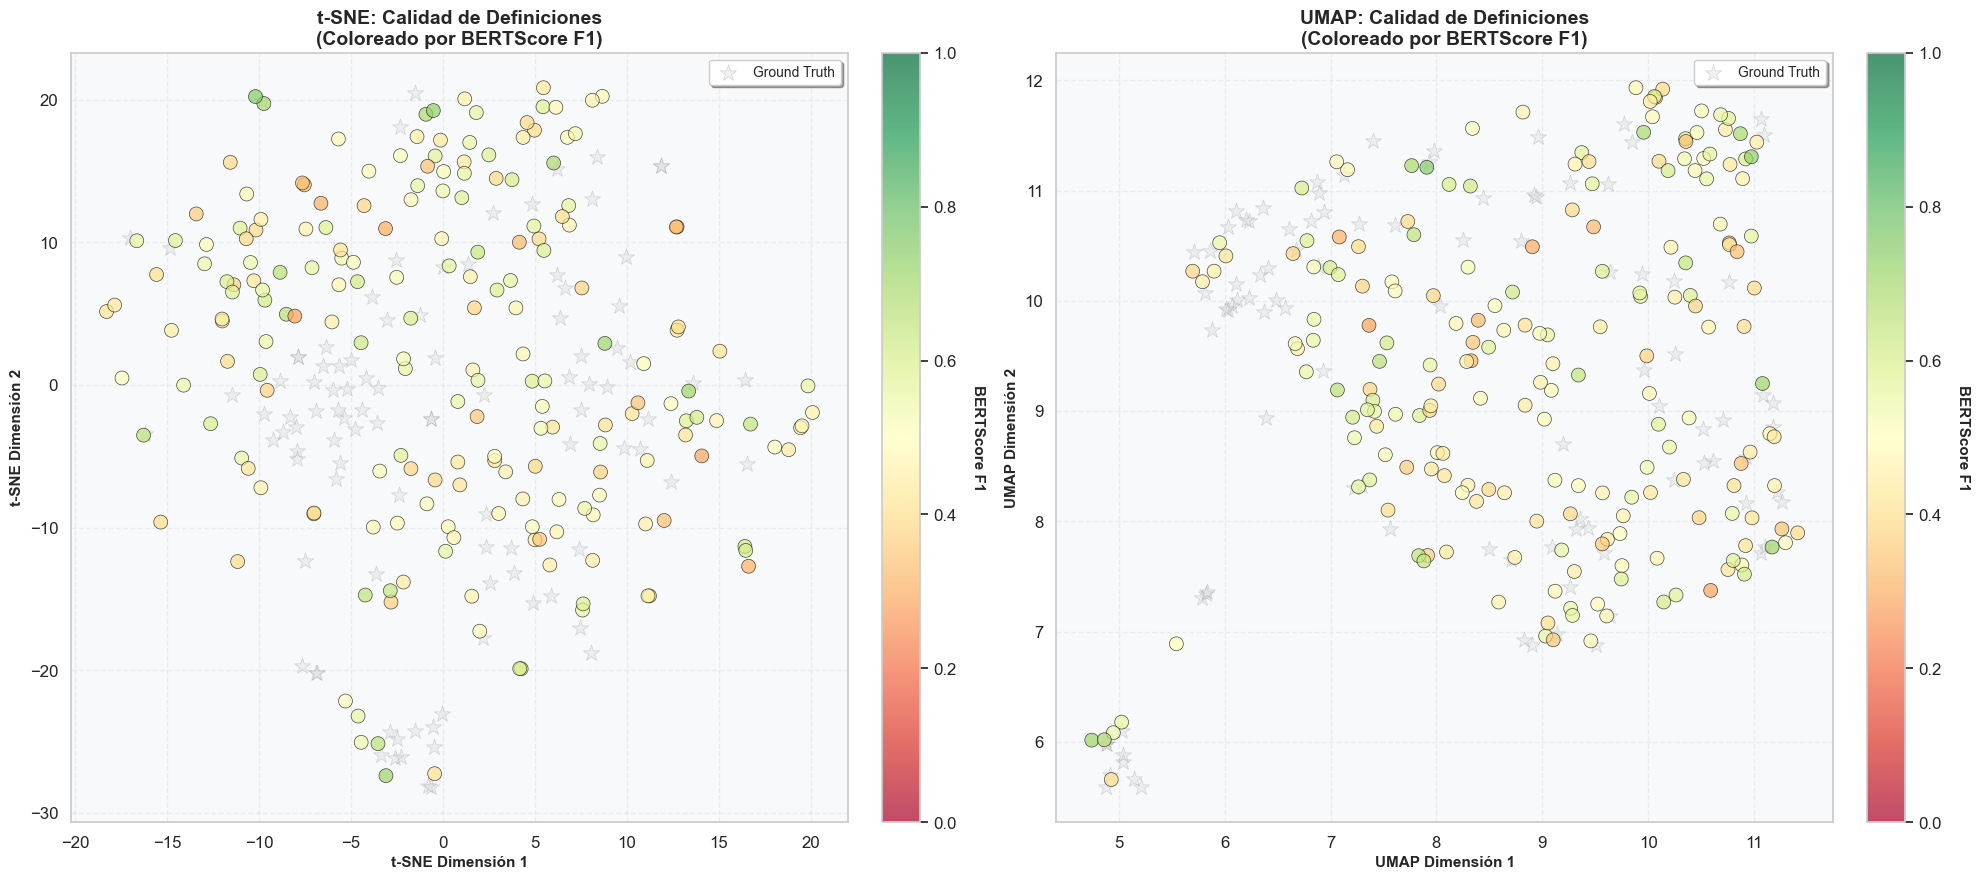


INTERPRETACIÓN:
   • Verde: Definiciones de alta calidad (BERTScore F1 alto)
   • Amarillo: Calidad media
   • Rojo: Definiciones de baja calidad
   • Puntos cerca de Ground Truth (gris) = Semánticamente más similares


In [20]:
print("="*80)
print("Visualización coloreada por score (calidad de definición)...")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Filtrar solo las definiciones generadas (no Ground Truth)
mask_generated = all_labels_array != 'Ground Truth'

# ====================================================================
# 1. t-SNE coloreado por score
# ====================================================================
ax1 = axes[0]

# Ground Truth (fondo)
mask_gt = all_labels_array == 'Ground Truth'
ax1.scatter(coords_tsne[mask_gt, 0], coords_tsne[mask_gt, 1],
           c='lightgray', s=150, alpha=0.3, marker='*',
           edgecolors='gray', linewidth=0.5, label='Ground Truth')

# Definiciones generadas coloreadas por score
scatter1 = ax1.scatter(coords_tsne[mask_generated, 0], 
                      coords_tsne[mask_generated, 1],
                      c=all_scores_array[mask_generated],
                      cmap='RdYlGn',
                      s=100,
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=0.5,
                      vmin=0, vmax=1)

ax1.set_title('t-SNE: Calidad de Definiciones\n(Coloreado por BERTScore F1)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dimensión 1', fontsize=11, fontweight='bold')
ax1.set_ylabel('t-SNE Dimensión 2', fontsize=11, fontweight='bold')
ax1.legend(fontsize=10, loc='best', frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

cbar1 = plt.colorbar(scatter1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('BERTScore F1', rotation=270, labelpad=20, fontsize=11, fontweight='bold')

# ====================================================================
# 2. UMAP coloreado por score
# ====================================================================
ax2 = axes[1]

# Ground Truth (fondo)
ax2.scatter(coords_umap[mask_gt, 0], coords_umap[mask_gt, 1],
           c='lightgray', s=150, alpha=0.3, marker='*',
           edgecolors='gray', linewidth=0.5, label='Ground Truth')

# Definiciones generadas coloreadas por score
scatter2 = ax2.scatter(coords_umap[mask_generated, 0], 
                      coords_umap[mask_generated, 1],
                      c=all_scores_array[mask_generated],
                      cmap='RdYlGn',
                      s=100,
                      alpha=0.7,
                      edgecolors='black',
                      linewidth=0.5,
                      vmin=0, vmax=1)

ax2.set_title('UMAP: Calidad de Definiciones\n(Coloreado por BERTScore F1)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP Dimensión 1', fontsize=11, fontweight='bold')
ax2.set_ylabel('UMAP Dimensión 2', fontsize=11, fontweight='bold')
ax2.legend(fontsize=10, loc='best', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

cbar2 = plt.colorbar(scatter2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('BERTScore F1', rotation=270, labelpad=20, fontsize=11, fontweight='bold')

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'tsne_umap_scores.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Visualización guardada en: {output_fig}")
print("="*80)

plt.show()

print("\nINTERPRETACIÓN:")
print("   • Verde: Definiciones de alta calidad (BERTScore F1 alto)")
print("   • Amarillo: Calidad media")
print("   • Rojo: Definiciones de baja calidad")
print("   • Puntos cerca de Ground Truth (gris) = Semánticamente más similares")
print("="*80)

Scatter plots anotados: Identificando casos problemáticos...
✓ Scatter plots anotados guardados en: Metricas_Resultados/scatter_plots_anotados.png
✓ Scatter plots anotados guardados en: Metricas_Resultados/scatter_plots_anotados.png


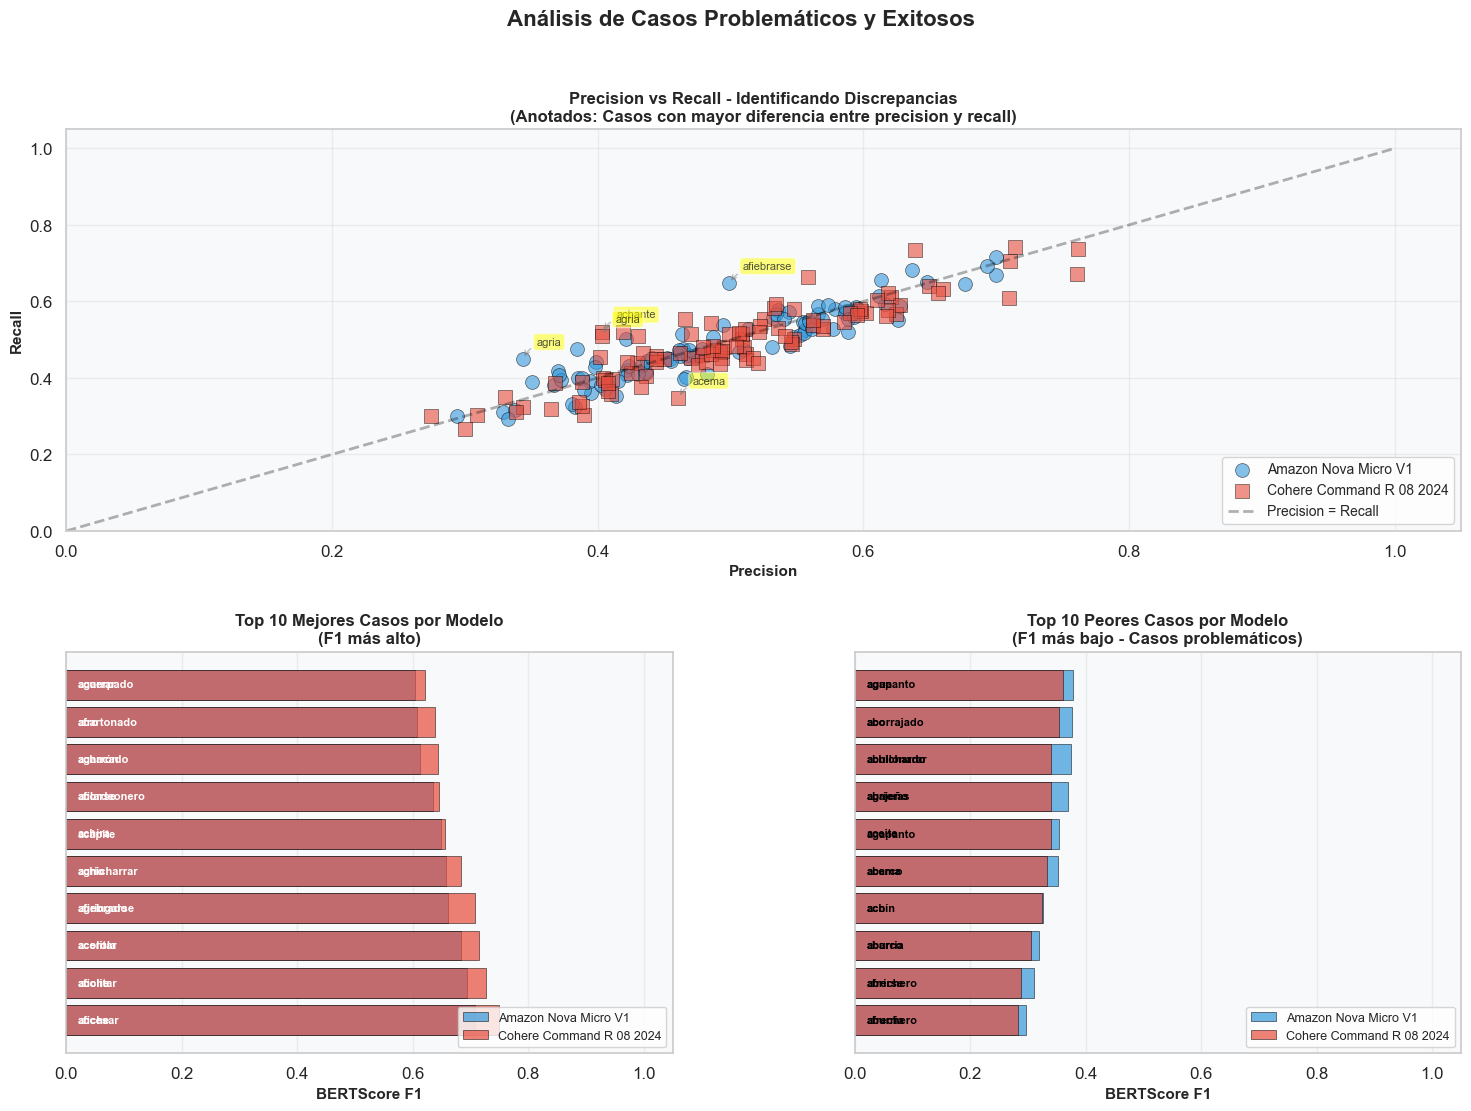


RESUMEN DE CASOS PROBLEMÁTICOS:
--------------------------------------------------------------------------------

Amazon Nova Micro V1 - 3 Peores casos:
   • 'aburria' - F1: 0.297
     Real: Ave de hasta 70 cm de longitud, de cabeza pequeña, cuello largo y delgado, patas...
     Generada: Actitud de aburrirse o mostrarse desinteresado en algo....

   • 'afrechero' - F1: 0.311
     Real: Ave de hasta 16 cm de longitud, de coloración blanquecina o gris en el pecho y e...
     Generada: Comportamiento de hacer algo sin necesidad, generando desorden o molestia....

   • 'abarco' - F1: 0.320
     Real: Árbol maderable que alcanza una altura hasta 50 m, de hojas lanceoladas, follaje...
     Generada: Incluir o abarcar una situación completa o todos los aspectos....


Cohere Command R 08 2024 - 3 Peores casos:
   • 'afrechero' - F1: 0.283
     Real: Ave de hasta 16 cm de longitud, de coloración blanquecina o gris en el pecho y e...
     Generada: Persona que es mal hablada o grosera....

   

In [21]:
print("="*80)
print("Scatter plots anotados: Identificando casos problemáticos...")
print("="*80)

# Crear figura con 3 gráficos (eliminamos el BERTScore vs AlignScore por falta de datos)
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, :])  # Top row, full width
ax3 = fig.add_subplot(gs[1, 0])  # Bottom left
ax4 = fig.add_subplot(gs[1, 1])  # Bottom right

fig.suptitle('Análisis de Casos Problemáticos y Exitosos', 
             fontsize=16, fontweight='bold')

# ====================================================================
# 1. BERTScore: Precision vs Recall
# ====================================================================

for model, color, marker in zip(MODEL_NAMES, ['#3498db', '#e74c3c'], ['o', 's']):
    df_model = df_resultados_p1[df_resultados_p1['modelo'] == model]
    
    ax1.scatter(df_model['precision'], df_model['recall'],
               label=model.replace('_', ' '),
               color=color, s=100, alpha=0.6,
               edgecolors='black', linewidth=0.5, marker=marker)

# Línea diagonal (precision = recall)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2, label='Precision = Recall')

# Anotar casos extremos
combined_df = df_resultados_p1.copy()
combined_df['discrepancia'] = abs(combined_df['precision'] - combined_df['recall'])

# Top 5 casos con mayor discrepancia
top_discrepancy = combined_df.nlargest(5, 'discrepancia')
for idx, row in top_discrepancy.iterrows():
    if len(row['modismo']) > 20:
        label = row['modismo'][:17] + '...'
    else:
        label = row['modismo']
    
    ax1.annotate(label,
                (row['precision'], row['recall']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                              color='gray', alpha=0.5))

ax1.set_xlabel('Precision', fontsize=11, fontweight='bold')
ax1.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax1.set_title('Precision vs Recall - Identificando Discrepancias\n(Anotados: Casos con mayor diferencia entre precision y recall)', 
             fontsize=12, fontweight='bold')
ax1.legend(fontsize=10, loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1.05])
ax1.set_ylim([0, 1.05])
ax1.set_facecolor('#f8f9fa')

# ====================================================================
# 3. Mejores casos (F1 alto)
# ====================================================================

# Top 10 mejores casos por modelo
for model, color in zip(MODEL_NAMES, ['#3498db', '#e74c3c']):
    df_model = df_resultados_p1[df_resultados_p1['modelo'] == model]
    top10 = df_model.nlargest(10, 'f1_score')
    
    y_positions = range(len(top10))
    ax3.barh(y_positions, top10['f1_score'].values,
            label=model.replace('_', ' '), color=color, alpha=0.7,
            edgecolor='black', linewidth=0.5)
    
    # Anotar modismos
    for i, (idx, row) in enumerate(top10.iterrows()):
        if len(row['modismo']) > 25:
            label = row['modismo'][:22] + '...'
        else:
            label = row['modismo']
        
        ax3.text(0.02, i, label, va='center', fontsize=8, 
                fontweight='bold', color='white' if row['f1_score'] > 0.5 else 'black')

ax3.set_xlabel('BERTScore F1', fontsize=11, fontweight='bold')
ax3.set_title('Top 10 Mejores Casos por Modelo\n(F1 más alto)', 
             fontsize=12, fontweight='bold')
ax3.legend(fontsize=9, loc='lower right')
ax3.grid(True, alpha=0.3, axis='x')
ax3.set_xlim([0, 1.05])
ax3.set_yticks([])
ax3.set_facecolor('#f8f9fa')

# ====================================================================
# 4. Peores casos (F1 bajo)
# ====================================================================

# Bottom 10 peores casos por modelo
for model, color in zip(MODEL_NAMES, ['#3498db', '#e74c3c']):
    df_model = df_resultados_p1[df_resultados_p1['modelo'] == model]
    bottom10 = df_model.nsmallest(10, 'f1_score')
    
    y_positions = range(len(bottom10))
    ax4.barh(y_positions, bottom10['f1_score'].values,
            label=model.replace('_', ' '), color=color, alpha=0.7,
            edgecolor='black', linewidth=0.5)
    
    # Anotar modismos
    for i, (idx, row) in enumerate(bottom10.iterrows()):
        if len(row['modismo']) > 25:
            label = row['modismo'][:22] + '...'
        else:
            label = row['modismo']
        
        ax4.text(0.02, i, label, va='center', fontsize=8,
                fontweight='bold', color='white' if row['f1_score'] > 0.5 else 'black')

ax4.set_xlabel('BERTScore F1', fontsize=11, fontweight='bold')
ax4.set_title('Top 10 Peores Casos por Modelo\n(F1 más bajo - Casos problemáticos)', 
             fontsize=12, fontweight='bold')
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_xlim([0, 1.05])
ax4.set_yticks([])
ax4.set_facecolor('#f8f9fa')

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'scatter_plots_anotados.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Scatter plots anotados guardados en: {output_fig}")
print("="*80)

plt.show()

# Imprimir resumen de casos problemáticos
print("\nRESUMEN DE CASOS PROBLEMÁTICOS:")
print("-"*80)

for model in MODEL_NAMES:
    df_model = df_resultados_p1[df_resultados_p1['modelo'] == model]
    worst = df_model.nsmallest(3, 'f1_score')
    
    print(f"\n{model.replace('_', ' ')} - 3 Peores casos:")
    for idx, row in worst.iterrows():
        print(f"   • '{row['modismo']}' - F1: {row['f1_score']:.3f}")
        print(f"     Real: {row['definicion_real'][:80]}...")
        print(f"     Generada: {row['definicion_generada'][:80]}...")
        print()

print("="*80)